## Final Project Submission

Post Sale Opportunities in King County, WA

Three important questions.
<ul>
    <li>Is there a discernible geography pattern to the properties that have been sold in the time ? #### No</li>
    <li>What are the areas of high sales volume?</li>
    <li>Can we determine areas of high sales price?</li>
    <li>Combining features, what are areas of high volume with and high pricing and where are the new home sales in the county?</li>
</ul>




In [1]:
import numpy as np
import pandas as pd

import scipy.stats as scs

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as scs
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

import folium
from folium.plugins import HeatMap
import random

from sklearn.metrics import r2_score

import folium.plugins as HeatMapWithTime



target= 'price'

### Custom Function

In [2]:
def generateBaseMap(default_location=[40.693943, -73.985880], default_zoom_start=12):
    '''Create base map for the folium plot'''
    base_map = folium.Map(location=default_location, control_scale=True, titles= 'Stamen Toner')
    return base_map 
def feature_heatmap(data, feature_column= 'price', radius= 8):
    '''Create heatmap for given groupby dataframe with latitude and longitude data'''
    base_map = generateBaseMap(default_location=[data.lat.mean()-data.lat.std(), data.long.median()], default_zoom_start=9.0)
    HeatMap(data=data[['lat', 'long', feature_column]].groupby(['lat', 'long']).sum().reset_index().values.tolist(), radius= radius, max_zoom=13, min_opacity=.1).add_to(base_map)
    return base_map

See <a href="https://towardsdatascience.com/data-101s-spatial-visualizations-and-analysis-in-python-with-folium-39730da2adf">Spatial Visualizations and Analysis in Python with Folium</a>, for the source of functions.


In [3]:
def convert_cat_str_to_num(dataseries):
    '''Converting categorical feature in string from into arbituary numerical features'''
    count = 1
   
    for i in dataseries.unique():
        dataseries.loc[dataseries == i] = count
        count += 1
    return dataseries

def kfolds(data, k):
    #Force data as pandas dataframe
    data = pd.DataFrame(data)
    num_observations = len(data)
    fold_size = num_observations//k
    leftovers = num_observations%k
    folds = []
    start_obs = 0
    for fold_n in range(1,k+1):
        if fold_n <= leftovers:
            #Fold Size will be 1 larger to account for leftovers
            fold =  data.iloc[start_obs : start_obs+fold_size+1] 
            folds.append(fold)
            start_obs +=  fold_size + 1
        else:
            fold =  data.iloc[start_obs : start_obs+fold_size] 
            folds.append(fold)
            start_obs +=  fold_size
            
    return folds 

def resd_check(results, data, column):
    a=results.resid/results.resid.std()
    a = a.loc[a.abs() > 2]
    
    
    plt.figure(figsize= (13,8))
    sns.distplot(data[column].iloc[a.index])
    sns.distplot(data[column])
    plt.title('Checking Dist. Initial v. High,\n'+column)
    return

def binning_count(data_series, bins): # binning  numerical features
    data_series = data_series.astype(float)
    bins_rad = pd.cut(data_series, bins)
    print(bins_rad.isna().sum())
    bins_rad = bins_rad.cat.as_ordered()
    bins_rad = bins_rad.sort_values()
    return bins_rad.value_counts()

def binning(data_series, bins):
    data_series = data_series.astype(float)
    return pd.cut(data_series, bins)

def flip_diff(dataframe, column):
    """Adding new column to flip dataframe with the 
    difference of proceeding sales for given feature"""
    dataout=[]
    id_ = None
    previous_index = None
    for value in dataframe.id.unique():
            for index in dataframe.loc[dataframe.id == value].index:
                
                if id_ == dataframe.id.loc[index]:
                    dataout.append(dataframe[column].loc[index] - 
                                   dataframe[column].loc[previous_index])
                else:
                    dataout.append(np.nan)
                id_ = dataframe.id.loc[index]
                previous_index=index
    return dataout

#mean normalization
def mean_norm(dataseries):
    return (dataseries-dataseries.mean())/(dataseries.max()- dataseries.min())

#min-max scaling
def min_max(dataseries):
    return (dataseries-dataseries.min())/(dataseries.max()- dataseries.min())

def make_heatmap(data, columns=None, figsize=(20, 20)):
    if columns is None:
        corr = data.corr()
    else:
        corr = datadf[columns].corr()
    plt.figure(figsize=figsize)
    sns.heatmap(np.abs(corr), cmap=sns.color_palette('Blues'), annot=True, fmt='0.2g')
    plt.show()
    
def make_ols_model(df, target='price', columns_to_use=None, add_constant=True):
    
    '''Just build a model and see the output'''

    X = df[columns_to_use]
    y = df[target]

    # add a constant to my X
    if add_constant:
        X = sm.add_constant(X)
    
    ols = sm.OLS(y, X)
    results = ols.fit()
    print(results.summary())
    return ols, results

def make_ols_model1(df, target='price', columns_to_use=None, add_constant=True):
    
    '''Just build a model with summary'''

    X = df[columns_to_use]
    y = df[target]

    # add a constant to my X
    if add_constant:
        X = sm.add_constant(X)
    
    ols = sm.OLS(y, X)
    results = ols.fit()
    # print(results.summary())
    return ols, results


def scat_plot(data, column, target= 'price'):
    '''Provide scatterpolt for a given dataframe for a given column'''
    plt.figure(figsize= (13, 8))
    sns.scatterplot(x= data[column], y= data[target])

def bar_hist_plot(dataseries):
    plt.figure(figsize= (13, 8))
    a=dataseries.value_counts(sort=False);
    a.sort_index().plot(kind= 'barh')

def viol_plot(data, column, target= 'price'):
    plt.figure(figsize= (13, 8))
    sns.violinplot(x=column, y=target, data= data)

def equal_bin(dataseries):
    return [dataseries.min()-.01, dataseries.quantile(.25), dataseries.quantile(.5), 
            dataseries.quantile(.75), dataseries.max()]

def equal_bin10(dataseries, quantile_step=10):
    
    a = [dataseries.min()-.01]
    
    for quant in np.array(list(range(1,quantile_step)))/quantile_step:
        a.append(dataseries.quantile(quant))
    a.append(dataseries.max())  
    return a

def viol2(x, y):
    plt.figure(figsize= (13, 8))
    sns.violinplot(x=x, y=y)

from folium.plugins import HeatMap

### Gather Data

In [4]:
data = pd.read_csv('kc_house_data.csv')
data['ones'] = data.price* 0 + 1

In [5]:
data.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...   sqft_above  sqft_basement  \
0      5650     1.0         NaN   0.0  ...         1180            0.0   
1      7242     2.0         0.0   0.0  ...         2170          400.0   
2     10000     1.0         0.0   0.0  ...          770            0.0   
3      5000     1.0         0.0   0.0  ...         1050          910.0   
4      8080     1.0         0.0   0.0  ...         1680            0.0   

   yr_built yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955          0.0    98178  47.5112 -122.257           1340   
1      1951       1991.0    98125  47.7210 -122.319           1690   
2      1933          NaN    98028  47.7379 -122.233           2720   
3      1965          0.0    98136  47.5208 -122.393           1360   
4      1987          0.0    98074  47.6168 -122.045           1800   

   sqft_lot15  ones  
0        5650   1.0  
1        7639   1.0  
2        8062   1.0  
3        5000   1.0  
4        7503   1.0  

[5 rows x 22 columns]

In [6]:
data.info()
#  date, sqft_basement contain string a n

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
ones             21597 non-null float64
dtypes: float64(9), int64(11), obje

In [7]:
data.describe()
#'date' 'sqft_basement' not included.

id         price      bedrooms     bathrooms   sqft_living  \
count  2.159700e+04  2.159700e+04  21597.000000  21597.000000  21597.000000   
mean   4.580474e+09  5.402966e+05      3.373200      2.115826   2080.321850   
std    2.876736e+09  3.673681e+05      0.926299      0.768984    918.106125   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.159700e+04  21597.000000  19221.000000  21534.000000  21597.000000   
mean   1.509941e+04      1.494096      0.007596      0.233863      3.409825   
std    4.141264e+04      0.539683      0.086825      0.765686      0.650546   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.040000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.618000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.068500e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above      yr_built  yr_renovated       zipcode  \
count  21597.000000  21597.000000  21597.000000  17755.000000  21597.000000   
mean       7.657915   1788.596842   1970.999676     83.636778  98077.951845   
std        1.173200    827.759761     29.375234    399.946414     53.513072   
min        3.000000    370.000000   1900.000000      0.000000  98001.000000   
25%        7.000000   1190.000000   1951.000000      0.000000  98033.000000   
50%        7.000000   1560.000000   1975.000000      0.000000  98065.000000   
75%        8.000000   2210.000000   1997.000000      0.000000  98118.000000   
max       13.000000   9410.000000   2015.000000   2015.000000  98199.000000   

                lat          long  sqft_living15     sqft_lot15     ones  
count  21597.000000  21597.000000   21597.000000   21597.000000  21597.0  
mean      47.560093   -122.213982    1986.620318   12758.283512      1.0  
std        0.138552      0.140724     685.230472   27274.441950      0.0  
min       47.155900   -122.519000     399.000000     651.000000      1.0  
25%       47.471100   -122.328000    1490.000000    5100.000000      1.0  
50%       47.571800   -122.231000    1840.000000    7620.000000      1.0  
75%       47.678000   -122.125000    2360.000000   10083.000000      1.0  
max       47.777600   -121.315000    6210.000000  871200.000000      1.0

### Scrubbing the Data
Cleaning null values and placeholders

#### date
Convert string values to datetime64 format (yyyy-mm-dd)

In [8]:
data.date=pd.to_datetime(data.date)

#### sqft_basement
Changing 0 and ? to NaN, then back to zero.

In [9]:
a=data.sqft_basement.replace(to_replace= '?',value= np.nan)
a= a.astype(float)
data.sqft_basement= a.replace(to_replace= 0, value= np.nan)
data.sqft_basement=data.sqft_basement.fillna(value=0)
data.sqft_basement.describe()

count    21597.000000
mean       285.716581
std        439.819830
min          0.000000
25%          0.000000
50%          0.000000
75%        550.000000
max       4820.000000
Name: sqft_basement, dtype: float64

#### Used yr_built to make age

In [10]:
data['age'] = 2015- data.yr_built


#### yr_renovated 
Changing 0 to NaN  


In [11]:
data.yr_renovated = data.yr_renovated.replace(to_replace= 0, value= np.nan)

#### Using yr_renovated to make since_ren

In [12]:
data['since_ren'] = 2015- data.yr_renovated 

#### waterfront
Changing waterfront to NaN to 0.

In [13]:
data.waterfront = data.waterfront.fillna(value = 0)


#### view
Changing Nan values to 0

In [14]:
data.view = data.view.fillna(value= 0)

#### sqft_basement
Change NaN values to 0

In [15]:
data.sqft_basement = data.sqft_basement.fillna(value= 0)

#### yr_renovated
Change NaN values to 0

In [16]:
data.yr_renovated = data.yr_renovated.fillna(value= 0)

#### since_ren
Change NaN values to 0

In [17]:
data.since_ren = data.since_ren.fillna(value= 0)

#### renovated
Binary 0 or 1 (yes)

In [18]:
#data['renovated'] = data.yr_renovated
data['renovated']=data.yr_renovated.loc[data.yr_renovated != 0]/data.yr_renovated.loc[data.yr_renovated != 0]
data.renovated = data.renovated.fillna(value= 0)

In [19]:
data.grade.unique()

array([ 7,  6,  8, 11,  9,  5, 10, 12,  4,  3, 13], dtype=int64)

In [20]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'ones', 'age',
       'since_ren', 'renovated'],
      dtype='object')

#### month

In [21]:
data['month'] = data.date.dt.month

#### Creating a Possible Flipped Sale Database
We identified 177 resales of property that were sold in the period of study. We had two meanful features:

<li>change_date ---  The days between sales.<li>change_price --- The cost differential between the previous sale and current sale price.</li>
    
Condition and grade were examined, but there was no change between any of the sales.

Step of creating resale dataframe.
<ol>
    <li>Identify the property ids that are in the dataset more than once.</li>
    <li>Mark those id rows in the dataframe.</li>
    <li>Pulled marked rows into separate dataframe.</li>
    <li>Calculate difference in important features from one sale to another.</li>
    <li>Remove intial sales</li>
    
        

In [22]:
multiple = data.id.value_counts()
len(multiple.loc[multiple > 1])
resales = len(multiple.loc[multiple > 1])
# 176, The number of time a home has been resold in the time period.
resales/ len(data.id)
# Far less then 1% of homes have been sold in the time period.
multiple = multiple.loc[multiple > 1]
multiple = multiple.to_dict()
data['num_sales'] = data.id.map(multiple)
data['num_sales'] = data['num_sales'].fillna(1)
flip = data.loc[data.num_sales > 1]
data = data.drop(columns= 'num_sales')
flip = flip.sort_values('date')

# adding new column examine. 
flip['change_date'] = flip_diff(flip, 'date')

#flip = flip.change_date.apply(lambda x: x.days)      

flip['change_price'] = flip_diff(flip, 'price')

# Removing initial sales
flip = flip.dropna()

# converting timedelta to days
flip.change_date = flip.change_date.apply(lambda x: x.days)

# 
flip['percent_change'] = flip.change_price/(flip.price- flip.change_price)

### Data Condition

Methods for manipulating data to fit OLS assumptions.
<ul>
    <li>Binning values</li>
    <li>Playing with null values</li>
    <li>Normalizing data</li>
    <li>Standardizing data</li>
</ul>

Grouping data to create categories that might make sense for your data

#### id
Unique identified for a house. 
Although not valuable for predictive modeling, the feature id does identify homes that have been sold multiple times.

In [23]:

multiple = data.id.value_counts()
len(multiple.loc[multiple > 1])
resales = len(multiple.loc[multiple > 1])
# 176, The number of time a home has been resold in the time period.
print(resales)


176


In [24]:
# Far less then 1% of homes have been sold in the time period.
resales/ len(data.id)  

0.008149279992591563

#### date
The date  the house was sold. The initial value was a string value. The information was convert to a date. See Data Scrubbing section for more information. The date is 5/2/2014 to 5/27/2015. 



In [25]:
print(data.date.min(),'-',data.date.max())


2014-05-02 00:00:00 - 2015-05-27 00:00:00


The date range is 5/2/2014 to 5/27/2015

#### bedrooms
Number of Bedrooms/House
The initial values ranged from 1 to 33 bedrooms, but there are very fews value over 6. 


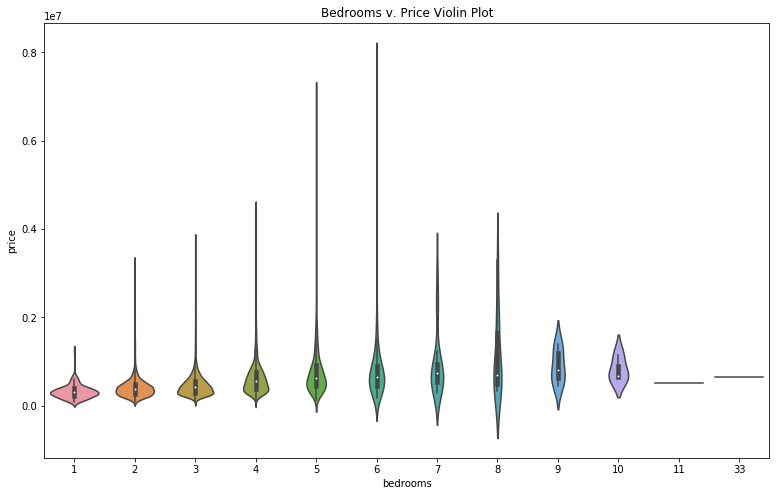

In [26]:
plt.figure(figsize= (13, 8))
sns.violinplot(x='bedrooms', y='price', data= data)
plt.title('Bedrooms v. Price Violin Plot');

#### Bedrooms v. Price Violin Plot
-skewed to data in all categories

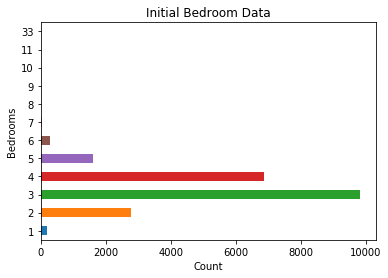

In [27]:
a=data.bedrooms.value_counts(sort=False);
a.sort_index().plot(kind= 'barh')
plt.title('Initial Bedroom Data');
plt.xlabel('Count');
plt.ylabel('Bedrooms');


The majority of the entries have 3 and 4 bedrooms. 

#### bathrooms
Number of bathrooms/bedrooms


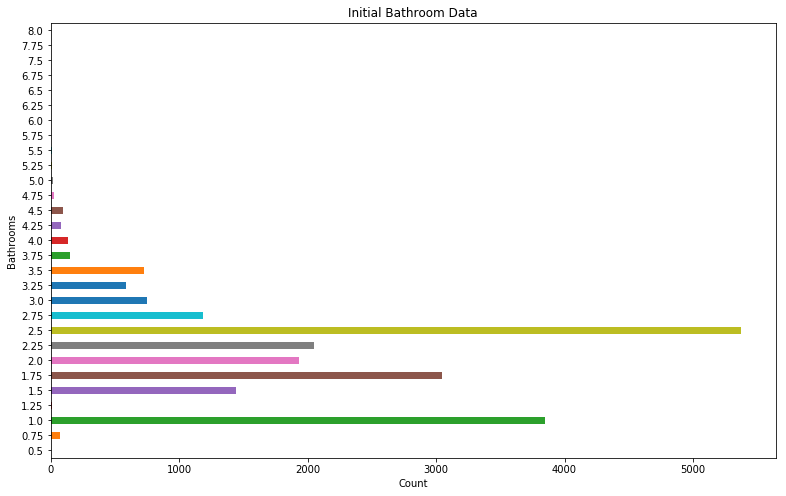

In [28]:
a=data.bathrooms.value_counts(sort=False);
plt.figure(figsize= (13, 8))
a.sort_index().plot(kind= 'barh')
plt.title('Initial Bathroom Data');
plt.xlabel('Count');
plt.ylabel('Bathrooms');

#### bin_bathroom
Create to see if it limited skewness. It did not help

Text(0, 0.5, 'Number of Bathrooms')

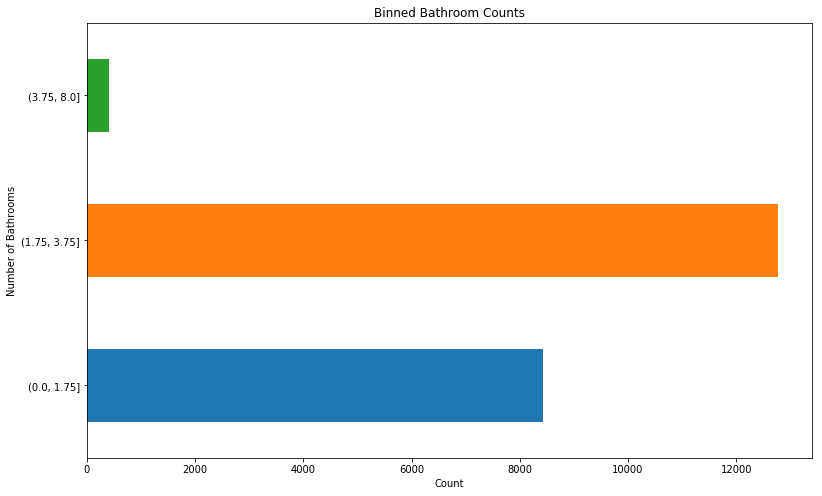

In [29]:
bins = [0, 1.75, 3.75, 8.0]
data['bin_bathrooms'] = binning(data['bathrooms'], bins)
bar_hist_plot(data['bin_bathrooms'])
plt.title('Binned Bathroom Counts')
plt.xlabel('Count')
plt.ylabel('Number of Bathrooms')

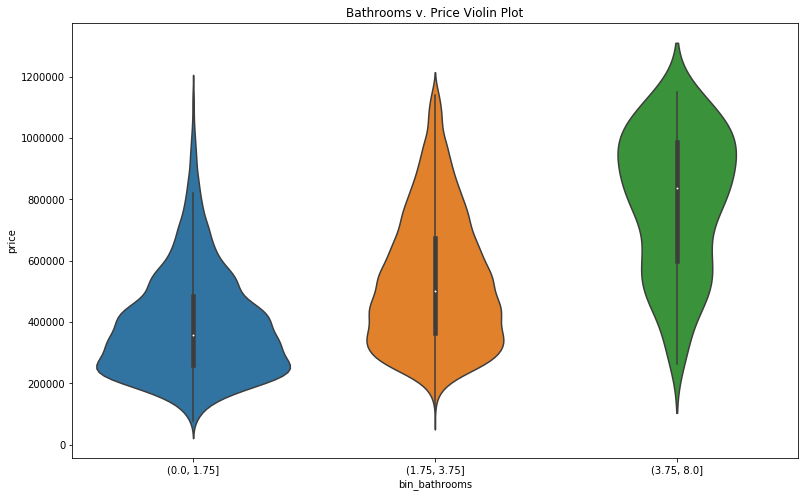

In [30]:
plt.figure(figsize= (13, 8))
sns.violinplot(x='bin_bathrooms', y='price', data= data.loc[data.price< data.price.quantile(.95)])
plt.title('Bathrooms v. Price Violin Plot');

In [31]:
data.bin_bathrooms = data.bin_bathrooms.astype(str)


data.bin_bathrooms.loc[data.bin_bathrooms == '(3.75, 8.0]'] = '1'
data.bin_bathrooms.loc[data.bin_bathrooms == '(0.0, 1.75]'] = '2'
data.bin_bathrooms.loc[data.bin_bathrooms == '(1.75, 3.75]'] = '3'
data.bin_bathrooms = data.bin_bathrooms.astype(int)

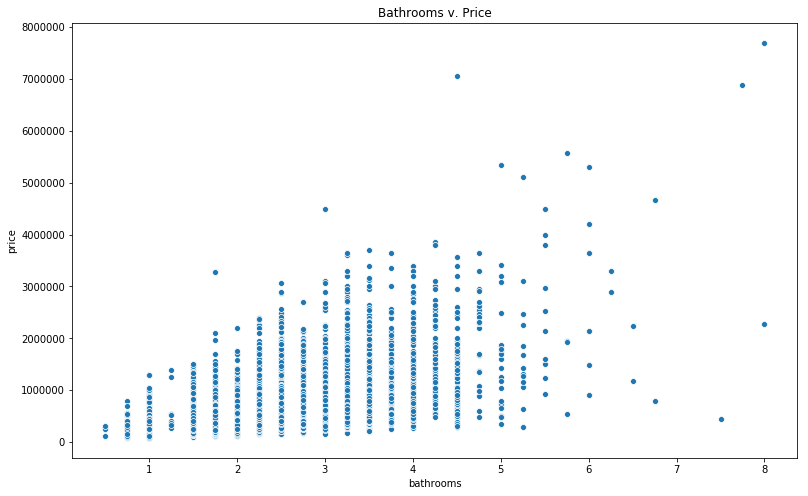

In [32]:
plt.figure(figsize= (13, 8))

#sns.violinplot(x= binning(data['bathrooms'],5), y= data[target]);
sns.scatterplot(x= data.bathrooms, y= data[target]);
plt.title('Bathrooms v. Price');

#### Bathroom 
<ul>
    <li>Skewed to data in all categories</li>
    <li>Simliar to bedroom</li>
    <li>High heteroscedasticity </li>
    <li>Seems to be a linearity relationship </li>
</ul>

#### sqft_living
Square footage of the home 

The range is 370 sqft to 13540 sqft. 

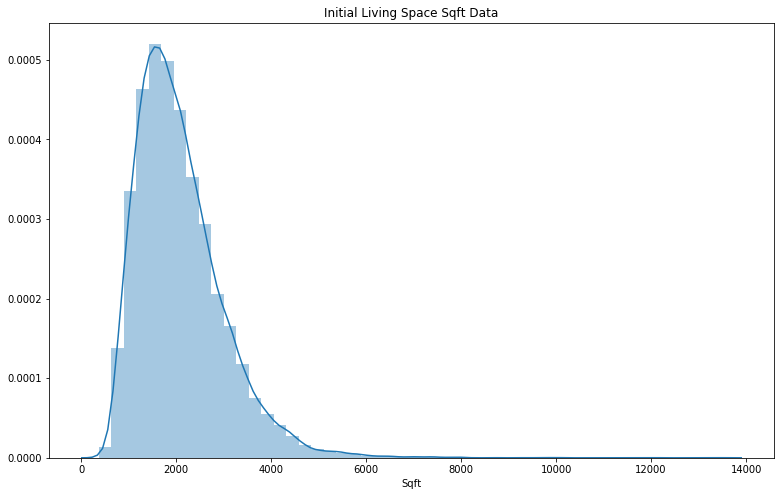

In [33]:
plt.figure(figsize= (13, 8))
sns.distplot(data.sqft_living)
plt.title('Initial Living Space Sqft Data');
plt.xlabel('Sqft');


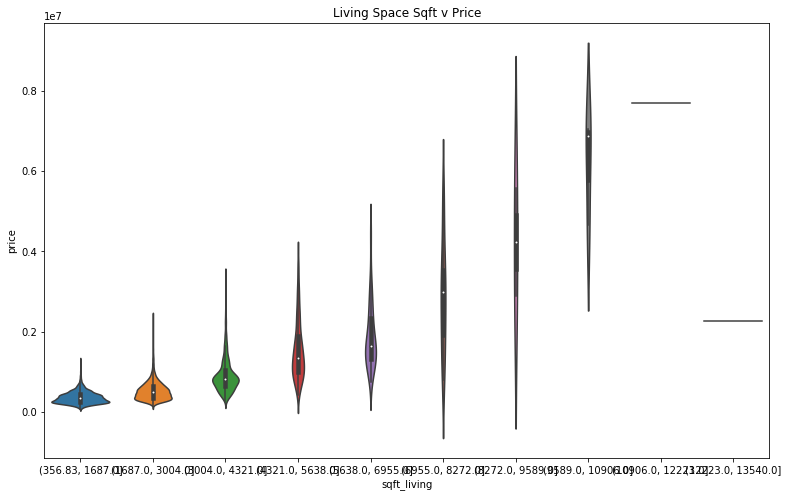

In [34]:
plt.figure(figsize= (13, 8))
sns.violinplot(x= binning(data['sqft_living'],10), y= data[target]);
plt.title('Living Space Sqft v Price');

<Figure size 936x576 with 0 Axes>

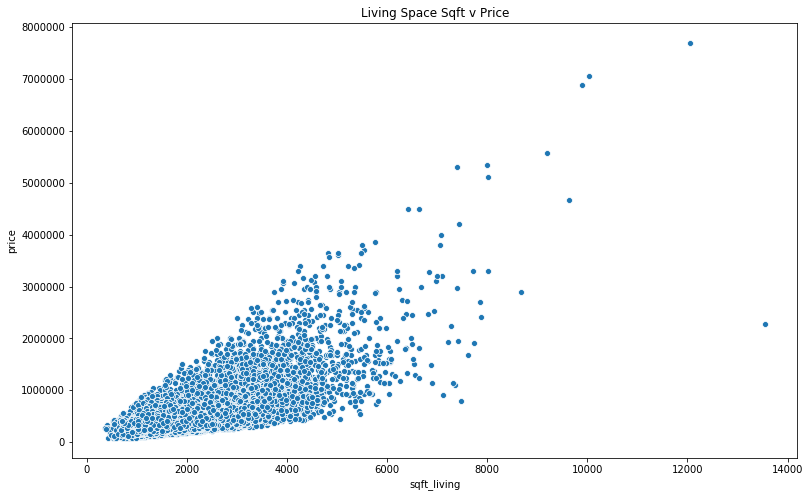

In [35]:
plt.figure(figsize= (13, 8));
scat_plot(data, 'sqft_living');
plt.title('Living Space Sqft v Price');

#### Square Footage for Living Space v. Price Violin Plot
<ul>
    <li>Skewed to data in all categories</li>
    <li>Seems nonlinear, may need log tranform (</li>
    <li>High heteroscedasticity </li>
</ul>

Creating data log_sqft_living and price_per_sqft_living (not used)

In [36]:
data['log_sqft_living'] = np.log(data["sqft_living"])

In [37]:
data['price_per_sqft_living'] = data.price/ data.sqft_living

##### sqft_lot
Square footage of the lot
The range is 520 sqft to 1,651,359 sqft.
<ul>
    <li>Highly skewed</li>
    <li>Not used</li>
</ul>

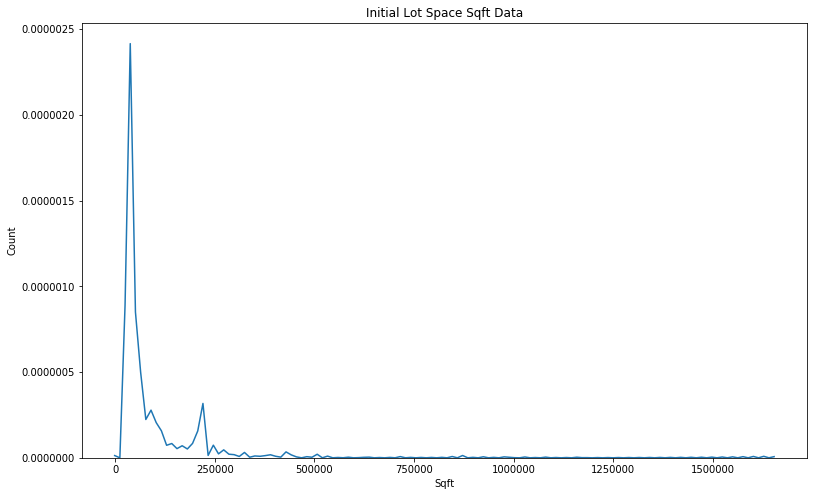

In [38]:
plt.figure(figsize= (13, 8))
sns.distplot(data.sqft_lot, hist=False)
plt.title('Initial Lot Space Sqft Data');
plt.xlabel('Sqft');
plt.ylabel('Count');

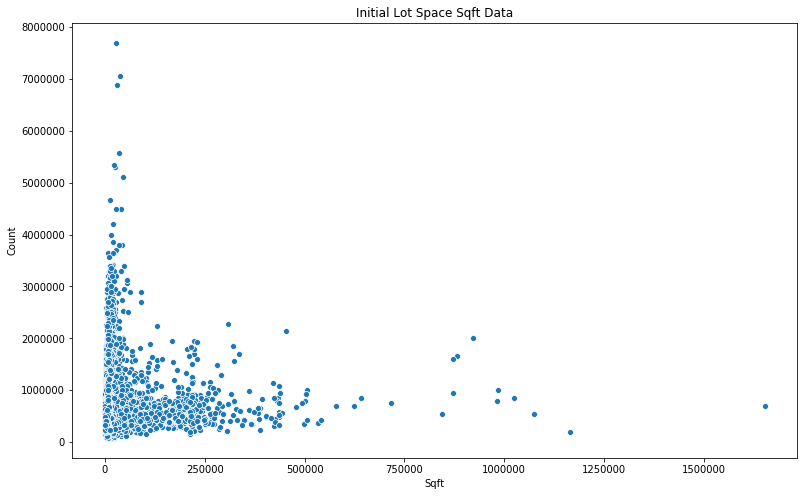

In [39]:
plt.figure(figsize= (13, 8))
sns.scatterplot(x= data.sqft_lot, y= data.price)
plt.title('Initial Lot Space Sqft Data');
plt.xlabel('Sqft');
plt.ylabel('Count');

#### floors
Total floors (levels) in house
The range is 1 to 3.5 floor. 

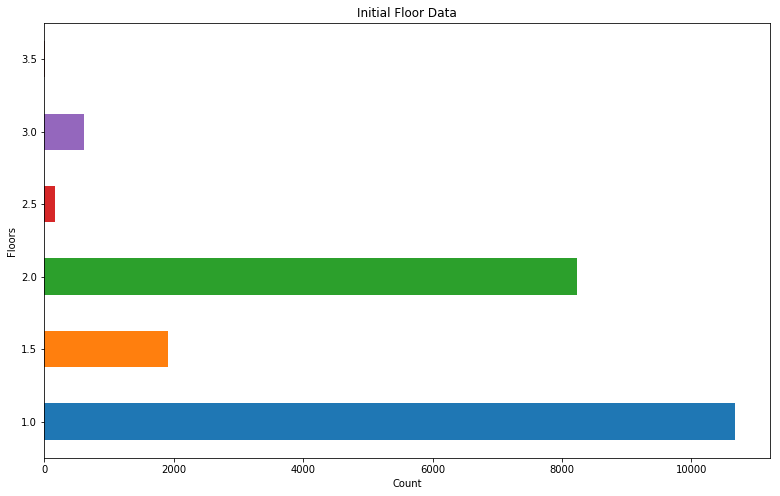

In [40]:
a=data.floors.value_counts(sort=False);
plt.figure(figsize= (13, 8))
a.sort_index().plot(kind= 'barh')
plt.title('Initial Floor Data');
plt.xlabel('Count');
plt.ylabel('Floors');

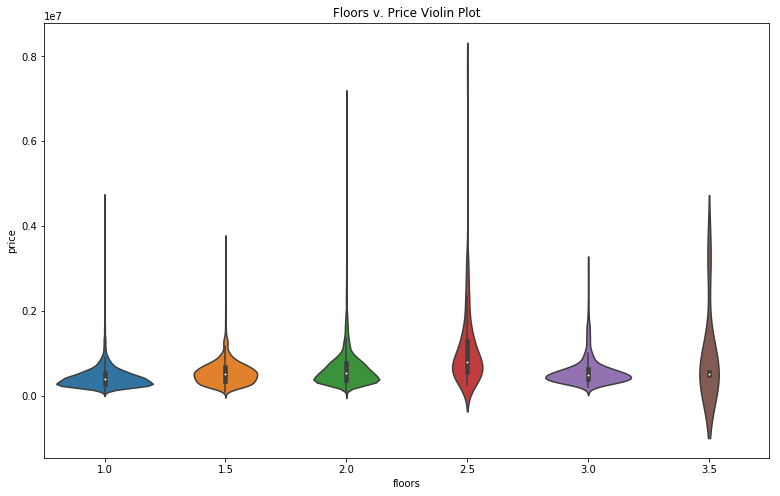

In [41]:
plt.figure(figsize= (13, 8))
sns.violinplot(x='floors', y='price', data= data)
plt.title('Floors v. Price Violin Plot');

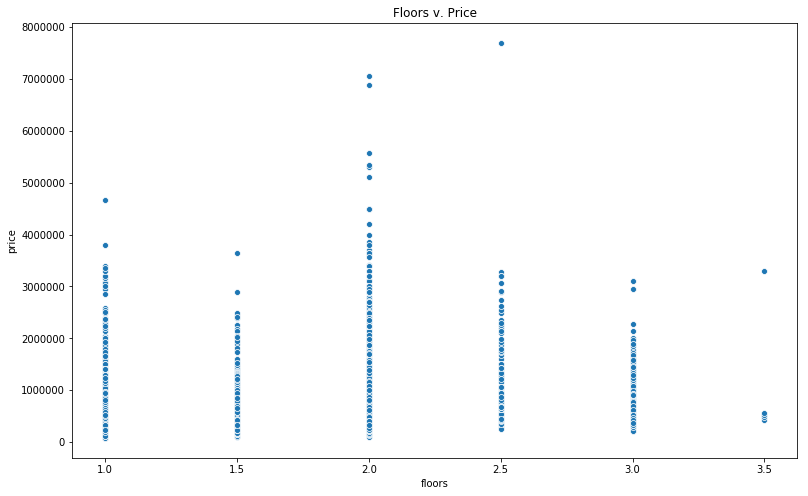

In [42]:
scat_plot(data, 'floors')
plt.title('Floors v. Price');

#### bin_floors
Rounded half sizes down.

In [43]:
bins= [0, 1.5, 2.5, 3.5]

In [44]:
a= binning(data.floors, bins).astype(str)


In [45]:
count = 1
for i in a.unique():
    b = a.loc[a == i]
    a.iloc[b.index] = count
    count += 1
data['bin_floors'] = a

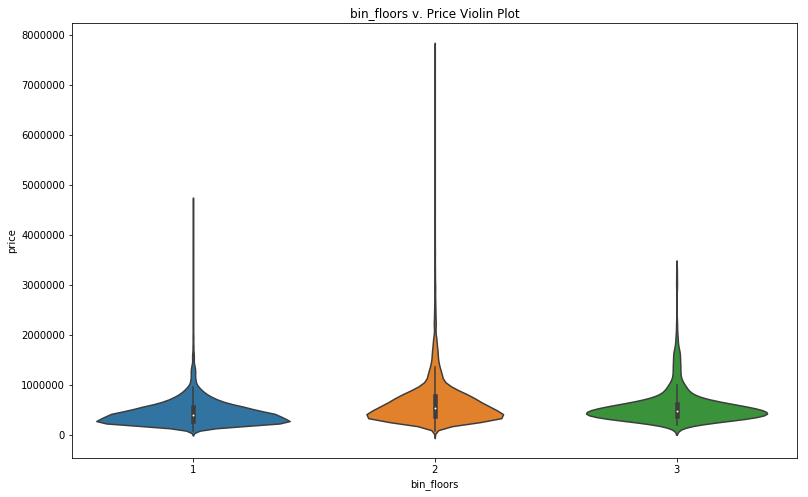

In [46]:
plt.figure(figsize= (13, 8))
sns.violinplot(x='bin_floors', y='price', data= data)
plt.title('bin_floors v. Price Violin Plot');

#### waterfront
House which has a view to a waterfront. Both values are skewed, but with waterfront is less skewed.



In [47]:
data.waterfront.value_counts()

0.0    21451
1.0      146
Name: waterfront, dtype: int64

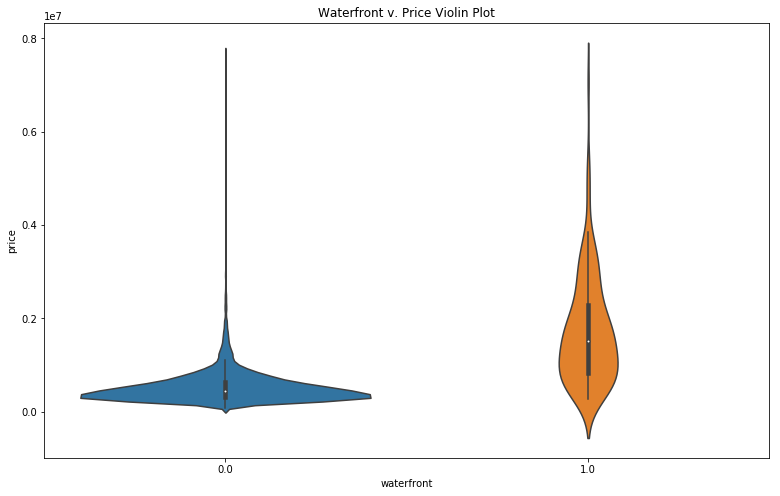

In [48]:
plt.figure(figsize= (13, 8))
sns.violinplot(x='waterfront', y='price', data= data)
plt.title('Waterfront v. Price Violin Plot');

#### view
Has been viewed
The range is 0 to 4.

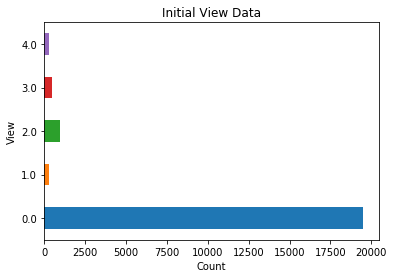

In [49]:
a = data.view.value_counts()
a.sort_index().plot(kind= 'barh')
plt.title('Initial View Data');
plt.xlabel('Count');
plt.ylabel('View');

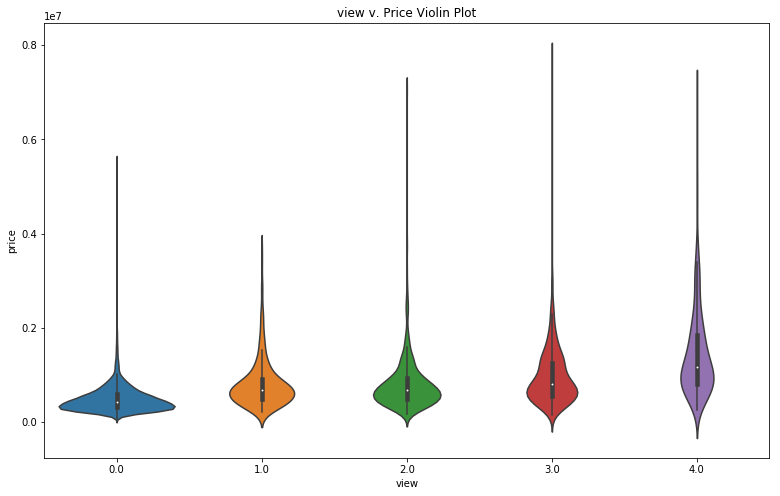

In [50]:
plt.figure(figsize= (13, 8))
sns.violinplot(x='view', y='price', data= data)
plt.title('view v. Price Violin Plot');

#### view Analysis
High skewedness

#### condition
How good the condition is ( Overall 
The range is 1 to 5.

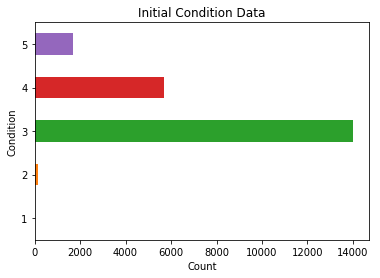

In [51]:
a = data.condition.value_counts()
a.sort_index().plot(kind= 'barh')
plt.title('Initial Condition Data');
plt.xlabel('Count');
plt.ylabel('Condition');

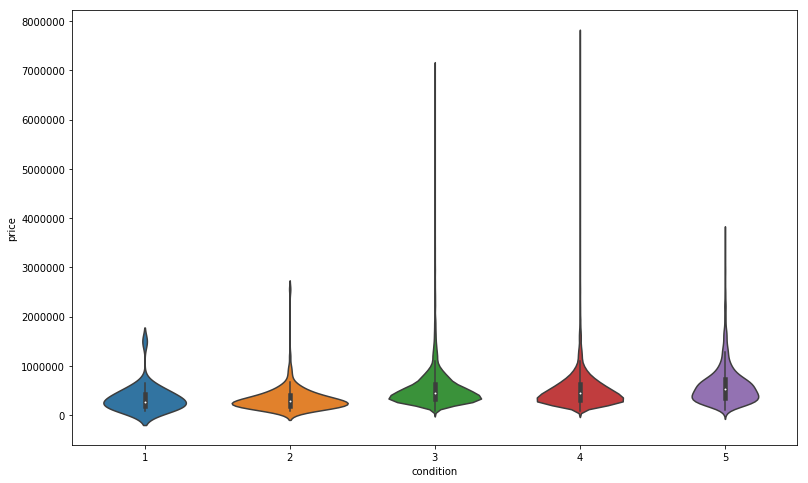

In [52]:
viol_plot(data, 'condition')

#### Analysis of Condition
High skewness in the high count values.

#### grade
overall grade given to the housing unit, based on King County grading system

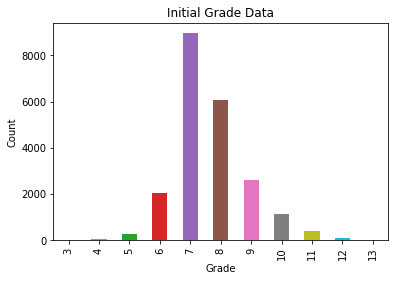

In [53]:
a = data.grade.value_counts()
a.sort_index().plot(kind= 'bar')
plt.title('Initial Grade Data');

plt.xlabel('Grade');
plt.ylabel('Count');

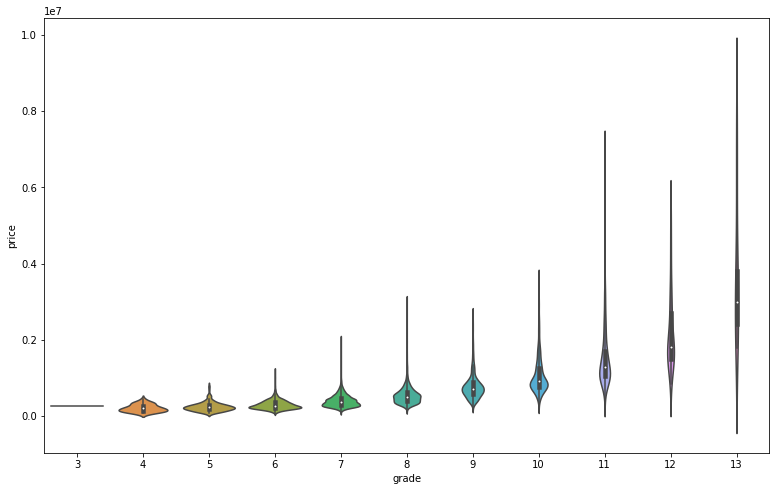

In [54]:
viol_plot(data, 'grade')

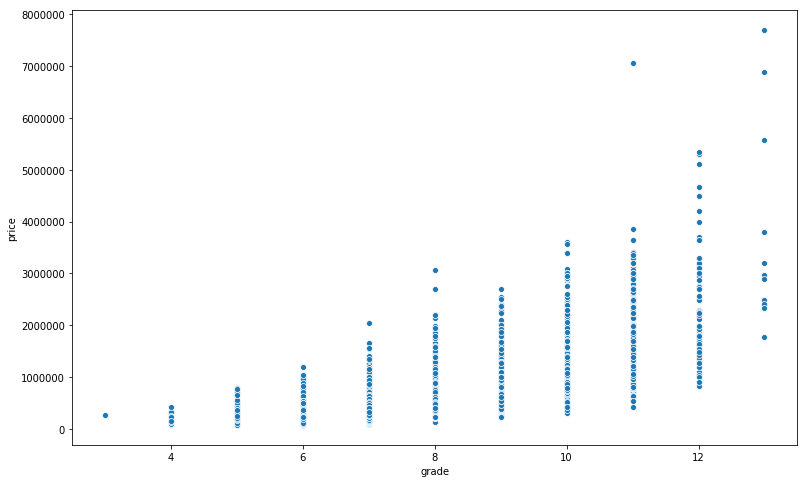

In [55]:
scat_plot(data, 'grade')

#### Analysis of Grade.
Skewness increase as the grade increases
High Heteroscedasticity, variability to increase as the grade goes up.

#### sqft_above
Square footage of house apart from basement

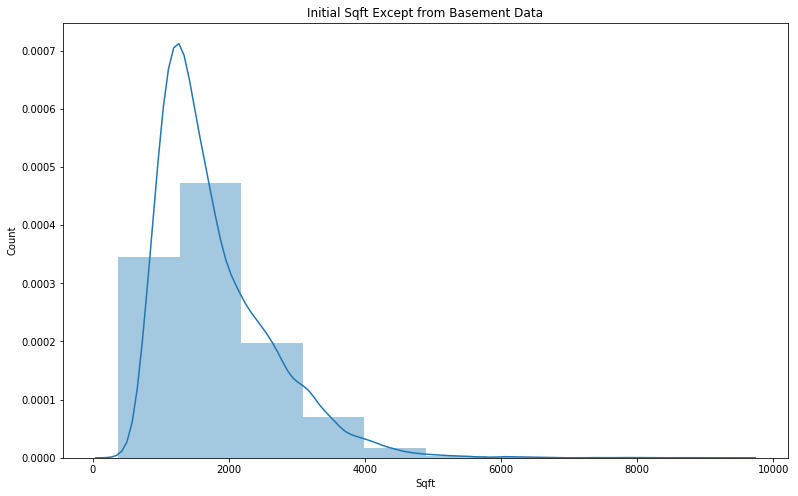

In [56]:

plt.figure(figsize= (13, 8))
sns.distplot(data.sqft_above, bins=10)
plt.title('Initial Sqft Except from Basement Data');
plt.xlabel('Sqft');
plt.ylabel('Count');

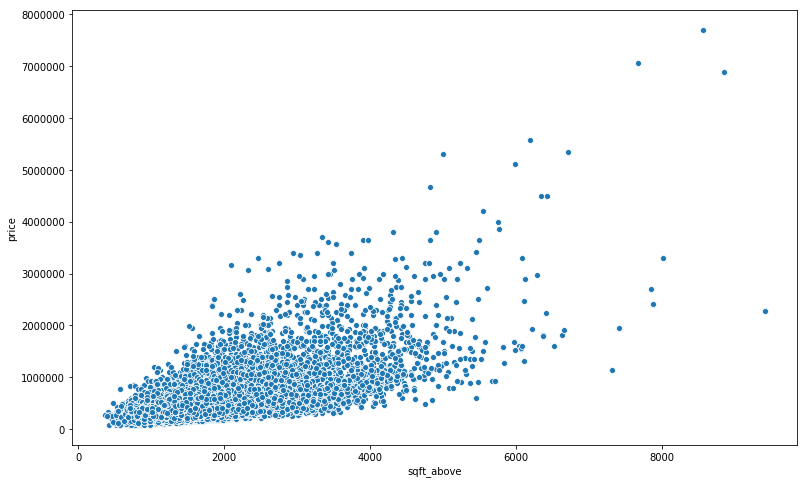

In [57]:
scat_plot(data, 'sqft_above')

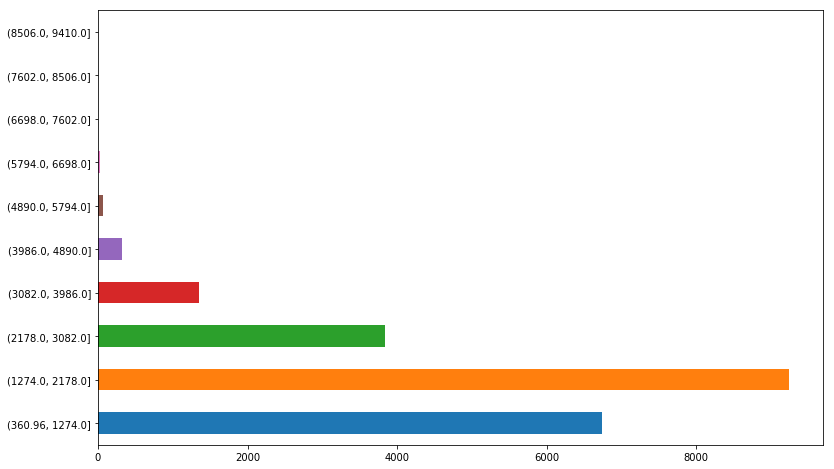

In [58]:
data['binning_sqft_above'] = binning(data.sqft_above, 10)

bar_hist_plot(data.binning_sqft_above)
data = data.drop(columns= 'binning_sqft_above')

#### Analysis of sqft_above
-High Heteroscedasticity 

#### sqft_basement
Square footage of the basement.  ? is the place hold value and the feature is formated as a string. See Data Scrubbing 

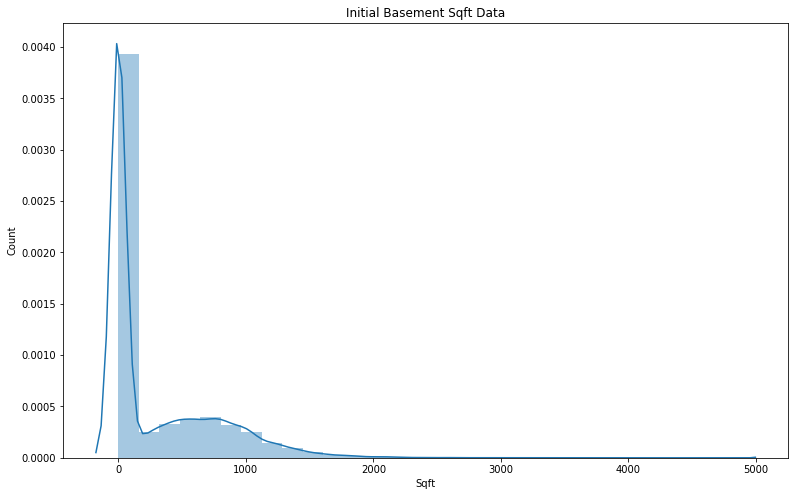

In [59]:
plt.figure(figsize= (13, 8))
sns.distplot(data.sqft_basement, bins=30)
plt.title('Initial Basement Sqft Data');
plt.xlabel('Sqft');
plt.ylabel('Count');

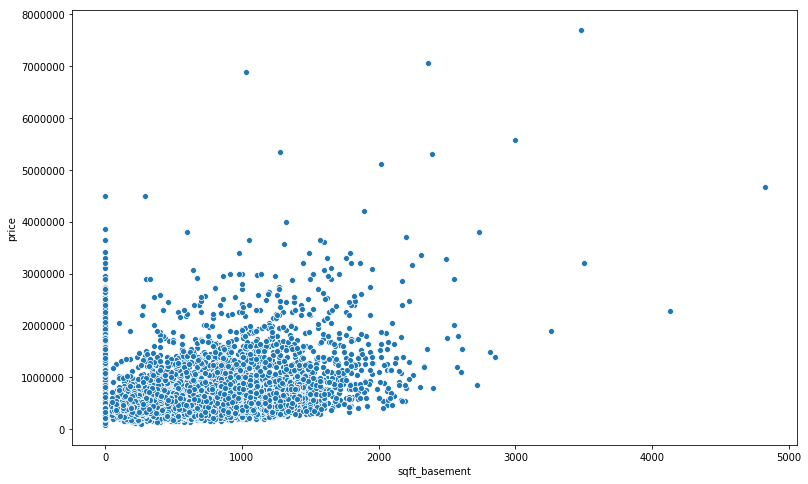

In [60]:
scat_plot(data, 'sqft_basement')

#### Analysis of sqft basement
-High Heteroscedasticity


#### yr_built
Built Year
The range is 1900 to 2015

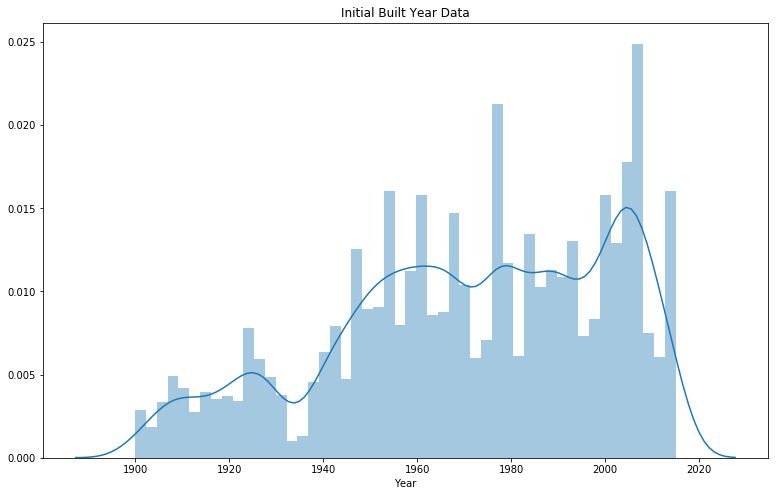

In [61]:
plt.figure(figsize= (13, 8))
sns.distplot(data.yr_built, bins=50)
plt.title('Initial Built Year Data');
plt.xlabel('Year');


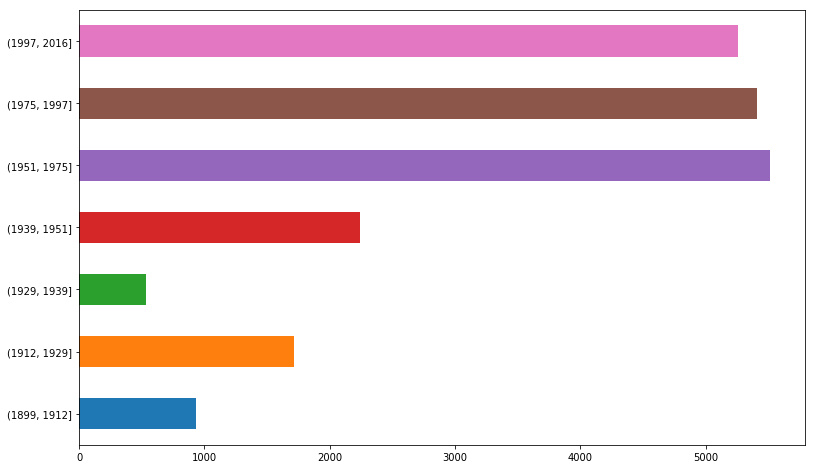

In [62]:
data.yr_built.describe()
[1899, 1951, 1975, 1997, 2015]
pd.cut(data.yr_built, [1899, 1912, 1929, 1939, 1951, 1975, 1997, 2016])

bar_hist_plot(pd.cut(data.yr_built, [1899, 1912, 1929, 1939, 1951, 1975, 1997, 2016]))


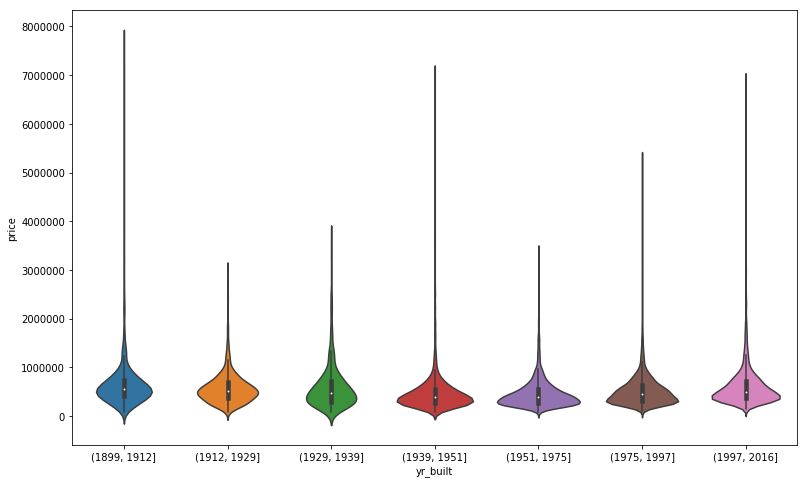

In [63]:
plt.figure(figsize=(13,8))
sns.violinplot(x= pd.cut(data.yr_built, [1899, 1912, 1929, 1939, 1951, 1975, 1997, 2016]), y= data.price);



#### yr_renovated
Year when house was renovated. The 744 have renovations.

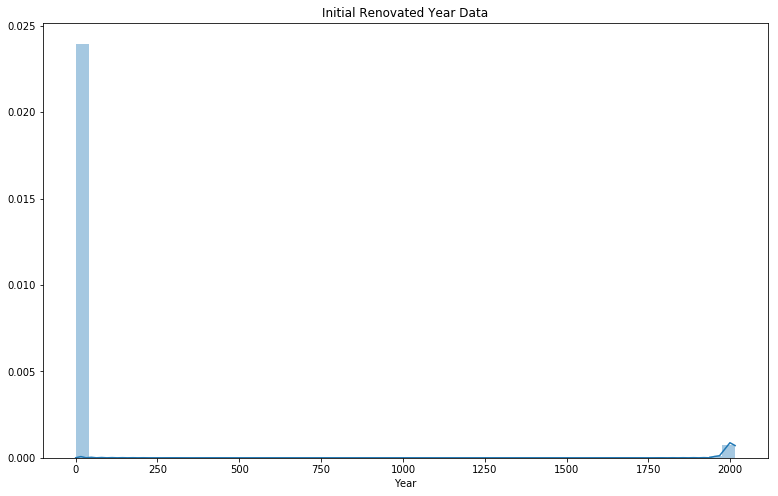

In [64]:
plt.figure(figsize= (13, 8))
sns.distplot(data.yr_renovated, bins=50)
plt.title('Initial Renovated Year Data');
plt.xlabel('Year');

#### zipcode

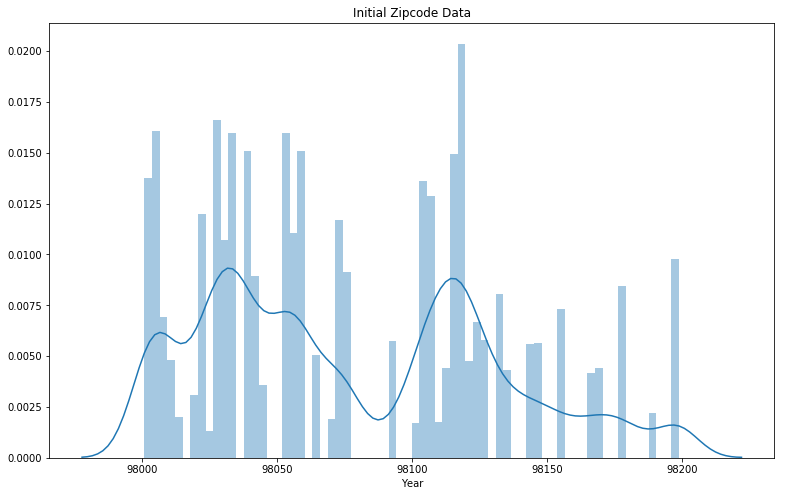

In [65]:
plt.figure(figsize= (13, 8))
sns.distplot(data.zipcode, bins=70)
plt.title('Initial Zipcode Data');
plt.xlabel('Year');

Zipcode is a categorical feature and does not lend it self to linear regression. The data will into a more usable form.It is an geographic area that could be associated with price using a pandas groupby method and statistic method like mean. 

Text(0.5, 1.0, 'Average Price by Zipcode v. Price')

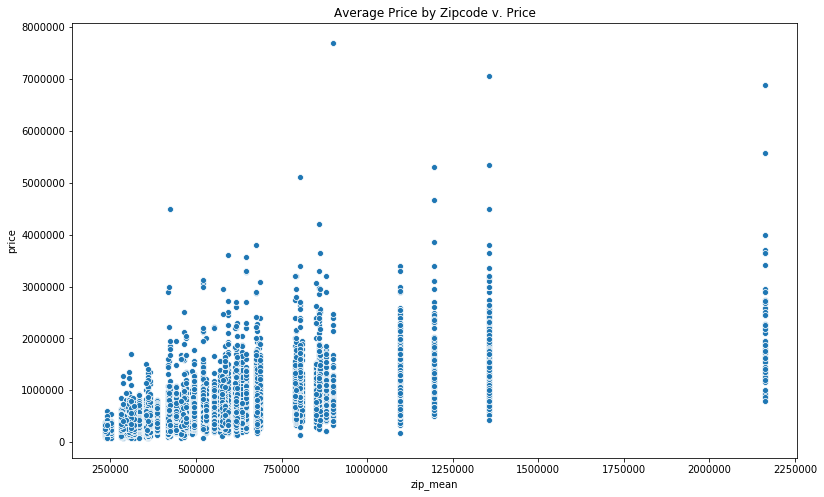

In [66]:
a=data.groupby(['zipcode'])['price'].mean()
data['zip_mean'] = data.zipcode.apply(lambda x: a[x])
scat_plot(data, 'zip_mean')
plt.title('Average Price by Zipcode v. Price')


count    2.159700e+04
mean     4.859554e+05
std      1.966655e+05
min      2.350000e+05
25%      3.350000e+05
50%      4.459500e+05
75%      5.720000e+05
max      1.895000e+06
Name: zip_median, dtype: float64

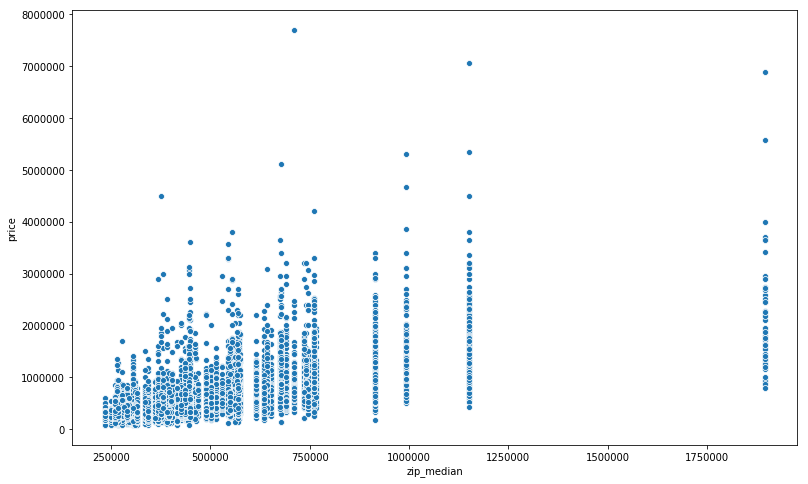

In [67]:
a=data.groupby(['zipcode'])['price'].median()
data['zip_median'] = data.zipcode.apply(lambda x: a[x])
scat_plot(data, 'zip_median')
data['zip_median'].describe()

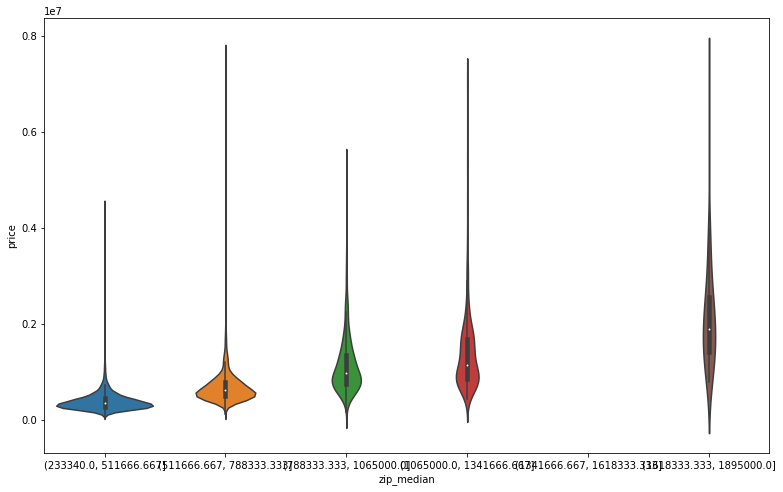

In [68]:
a= binning(data.zip_median, 6)
viol2(x=a, y=data.price)

count    2.159700e+04
mean     6.180254e+05
std      2.811627e+05
min      2.685000e+05
25%      4.052125e+05
50%      5.517500e+05
75%      7.190000e+05
max      2.560000e+06
Name: zip_75q, dtype: float64

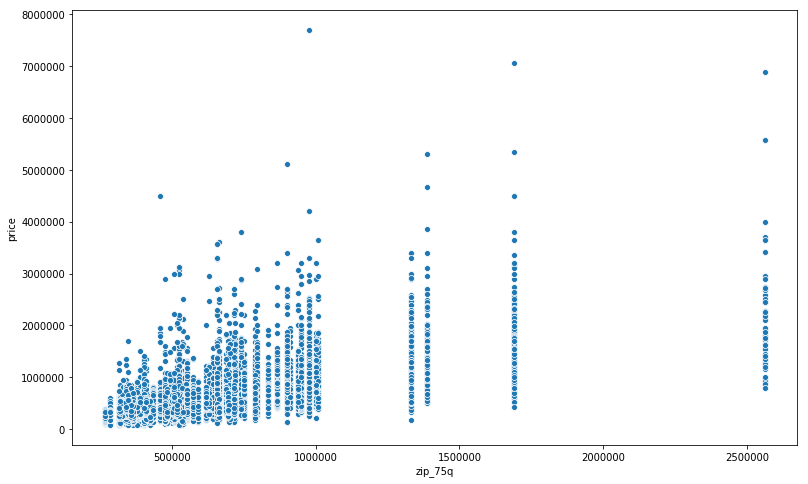

In [69]:
a=data.groupby(['zipcode'])['price'].quantile(.75)
data['zip_75q'] = data.zipcode.apply(lambda x: a[x])
scat_plot(data, 'zip_75q')
data['zip_75q'].describe()

In [70]:
a=data.groupby(['zipcode'])['price'].count()
data['zip_count'] = data.zipcode.apply(lambda x: a[x])

#### lat
Latitude coordinate. The range is 47.1559 to 47.7776

In [71]:
print(max(data.lat), min(data.lat))

47.7776 47.1559


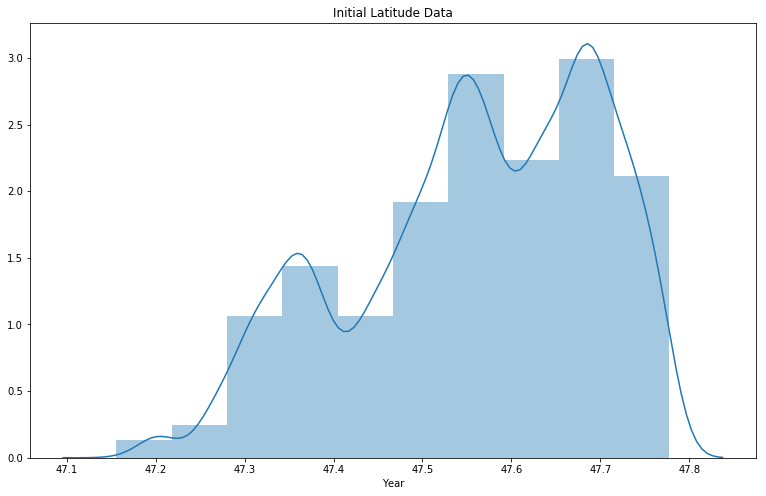

In [72]:
plt.figure(figsize= (13, 8))
sns.distplot(data.lat, bins=10)
plt.title('Initial Latitude Data');
plt.xlabel('Year');

In [73]:
a= data.groupby(['zipcode'])['lat'].median()
data['zip_median_lat'] = data.zipcode.apply(lambda x: a[x])
data['zip_EW'] = (data['zip_median_lat'] >= data.lat)*1


a= data.groupby(['zipcode', 'zip_EW'])['price'].median()
b=[]
for index in range(0,len(data)):
    b.append(a[data.zipcode.iloc[index]][data.zip_EW.iloc[index]])
data['sub_zip_median'] = b    



a= data.groupby(['zipcode', 'zip_EW'])['price'].quantile(.75)
b=[]
for index in range(0,len(data)):
    b.append(a[data.zipcode.iloc[index]][data.zip_EW.iloc[index]])
data['sub_zip_75q'] = b 


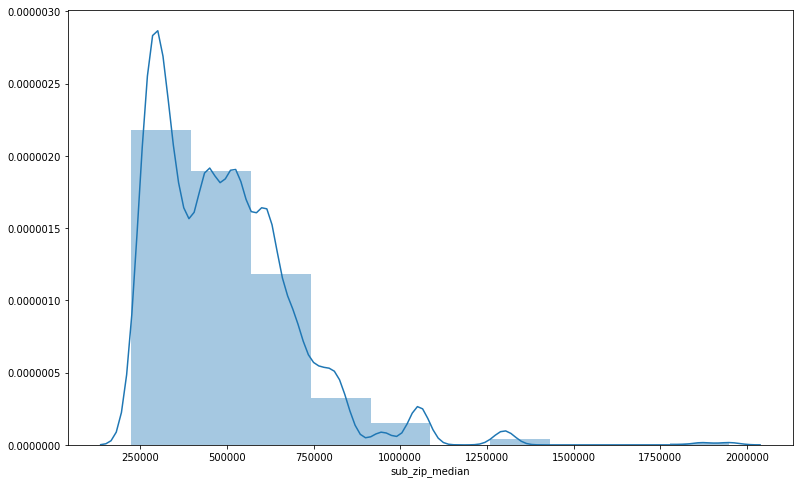

In [74]:
plt.figure(figsize= (13, 8))
sns.distplot(data['sub_zip_median'], bins=10);


#### long
Longitude coordinate

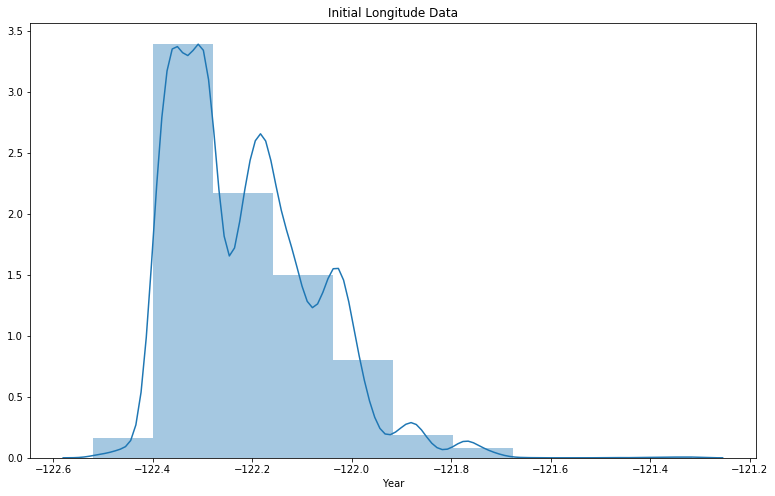

In [75]:
plt.figure(figsize= (13, 8))
sns.distplot(data.long, bins=10)
plt.title('Initial Longitude Data');
plt.xlabel('Year');

#### zone
Creates equal spaced zone boxes accross the latitude and longitude ranges of the dataset.

In [76]:
a = np.array(range(1,50+1))* (data.lat.max()-data.lat.min())/ 50+ data.lat.min()
a[0]= a[0]-1
data['bin_lat'] = binning(data.lat, a)
data['bin_lat']  = data['bin_lat'].astype(str)
data['bin_lat'] = data['bin_lat'].fillna('1')
print ( a[1],',',  a[2],'The length of box latitude', a[2]-a[1])
# Each bin is 0.86 miles long.


a = np.array(range(1,50+1))* (data.long.max()-data.long.min())/ 50+ data.long.min()
a[0]= a[0]-1
data['bin_long'] = binning(data.long, a)
data['bin_long'] = data['bin_long'].astype(str)
data['bin_long'] = data['bin_long'].fillna('1')
print ( a[1],',', a[2],',The length of box longitude', a[2]-a[1])
# Each bins is 1.131 miles long.
print(1.131* .86,' sq miles bins')
a = convert_cat_str_to_num(data['bin_lat'])
b = convert_cat_str_to_num(data['bin_long'])
data['zone'] = b*100 + a
#multipling longitude bin number by 100 and add to latitude bin 
#to create unique bin number for zone

47.180768 , 47.193202 The length of box latitude 0.012433999999998946
-122.47084 , -122.44676 ,The length of box longitude 0.02407999999999788
0.97266  sq miles bins


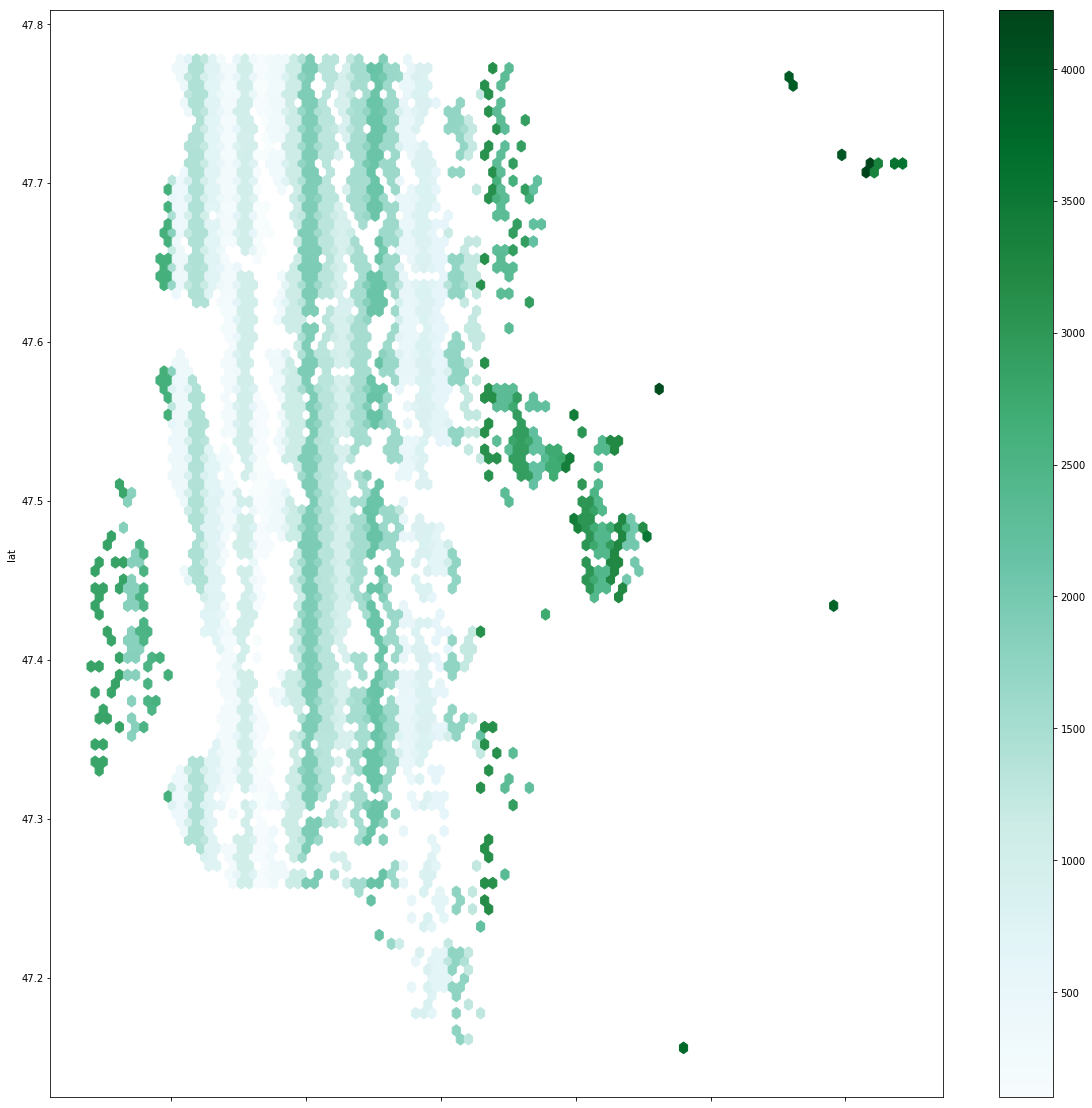

In [77]:

data.plot.hexbin(x='long', y='lat', C='zone', figsize=(20, 20))

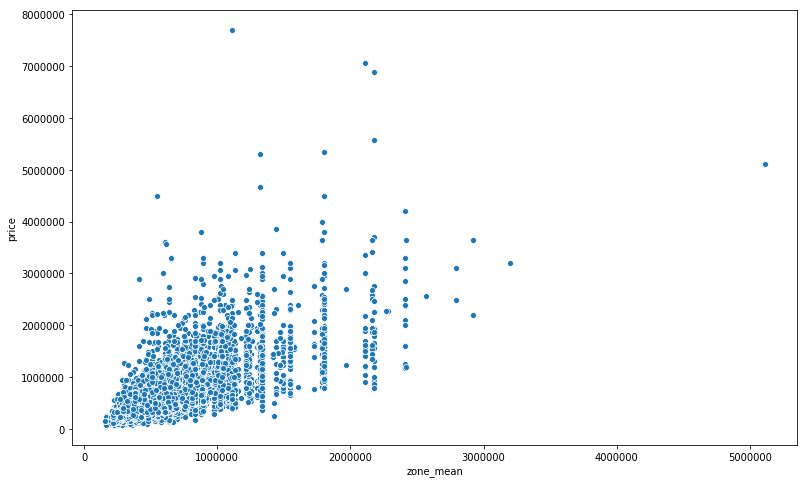

In [78]:
a= data.groupby(['zone'])['price'].mean()
data['zone_mean'] = data.zone.apply(lambda x: a[x])
scat_plot(data, 'zone_mean')
data['log_zone_mean'] = np.log(data['zone_mean'])

data['min_max_zone_mean'] = min_max(dataseries=data.zone_mean)


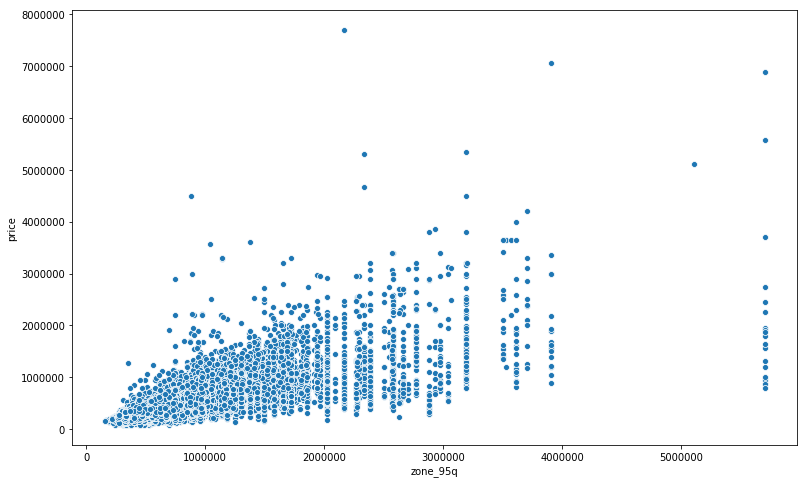

In [79]:
a= data.groupby(['zone'])['price'].quantile(.95)
data['zone_95q'] = data.zone.apply(lambda x: a[x])
scat_plot(data, 'zone_95q')

In [80]:
data['log_zone_95q'] = np.log(data['zone_95q'])

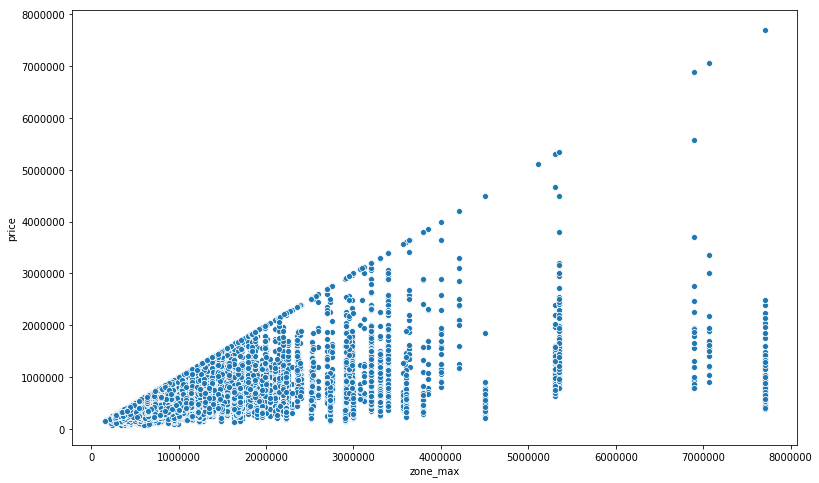

In [81]:
a= data.groupby(['zone'])['price'].max()
data['zone_max'] = data.zone.apply(lambda x: a[x])
scat_plot(data, 'zone_max')



In [82]:
a= data.groupby(['zone'])['price'].count()
data['zone_count'] = data.zone.apply(lambda x: a[x])

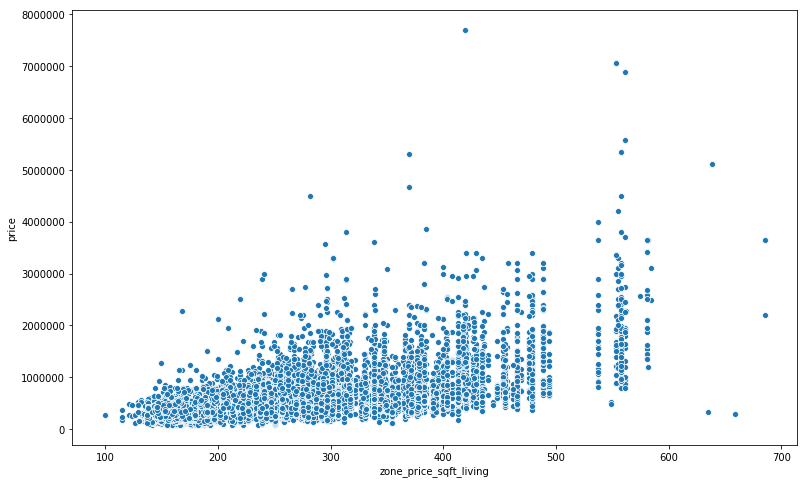

In [83]:

a= data.groupby(['zone'])['price_per_sqft_living'].mean()
data['zone_price_sqft_living'] = data.zone.apply(lambda x: a[x])
scat_plot(data, 'zone_price_sqft_living')


#### sqft_living15
The square footage of interior housing living space for the nearest 15 neighbors. The range is 399 to 6210 sq ft

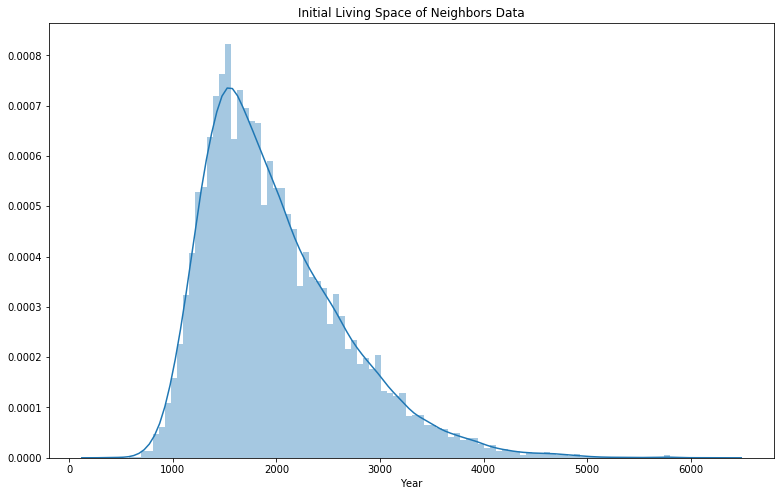

In [84]:
plt.figure(figsize= (13, 8))
sns.distplot(data.sqft_living15, bins=100)
plt.title('Initial Living Space of Neighbors Data');
plt.xlabel('Year');

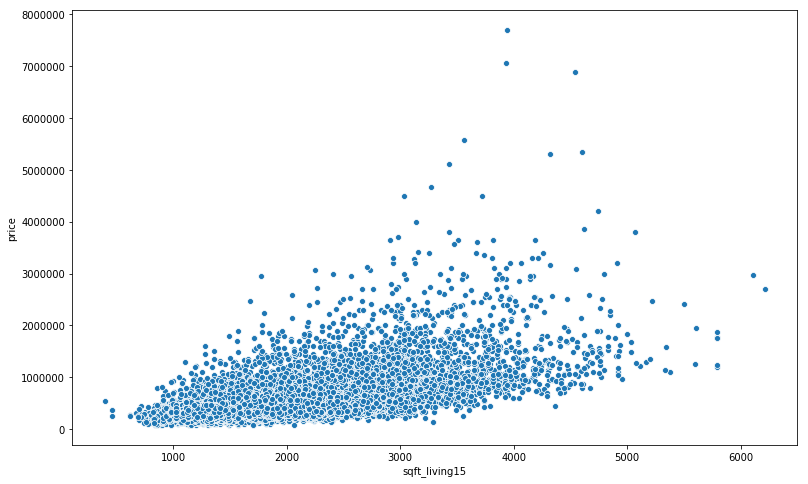

In [85]:
scat_plot(data, 'sqft_living15')

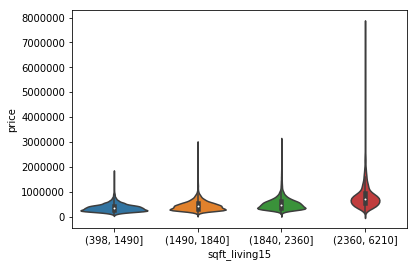

In [86]:
data.sqft_living15.describe()
sns.violinplot(x= binning(data.sqft_living15, [398, 1490, 1840, 2360, 6210]), y= data.price);

#### sqft_lot15
The square footage of the land lots of the nearest 15 neighbors. The range is 651 to 871,200 sq ft.

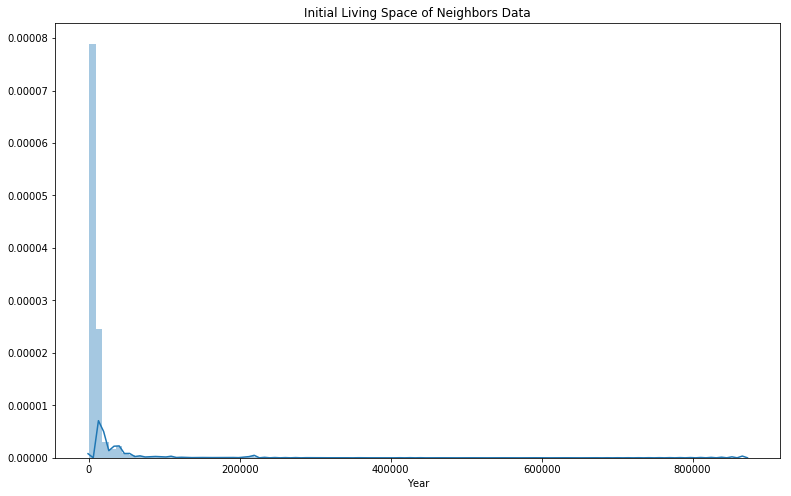

In [87]:
plt.figure(figsize= (13, 8))
sns.distplot(data.sqft_lot15, bins=100)
plt.title('Initial Living Space of Neighbors Data');
plt.xlabel('Year');

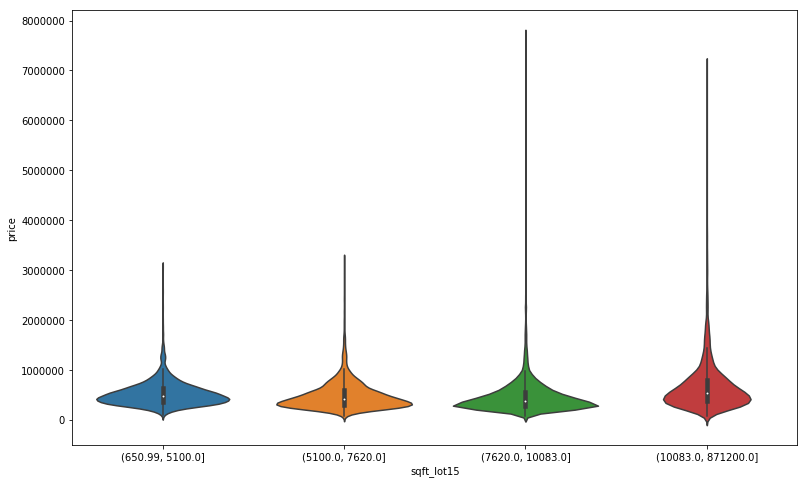

In [88]:

viol2(binning(data.sqft_lot15, equal_bin(data.sqft_lot15)), data.price)



#### change_date  (flip)


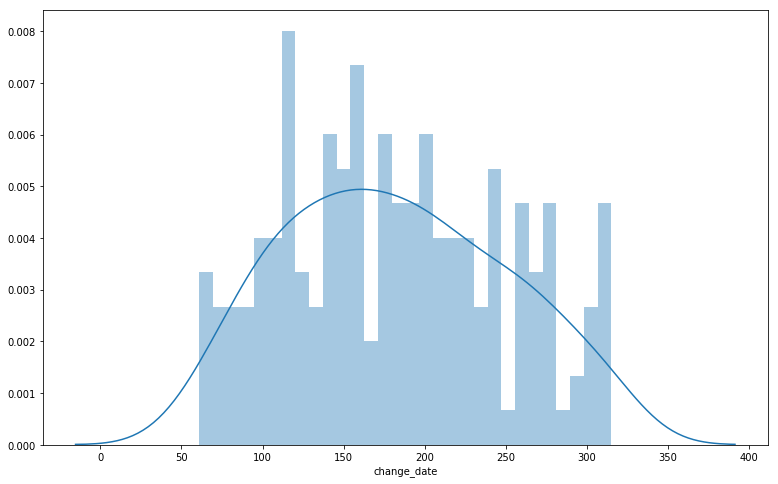

In [89]:
plt.figure(figsize= (13, 8))
sns.distplot(flip.change_date, bins=30);



#### month

January = 1, February = 2, ... 

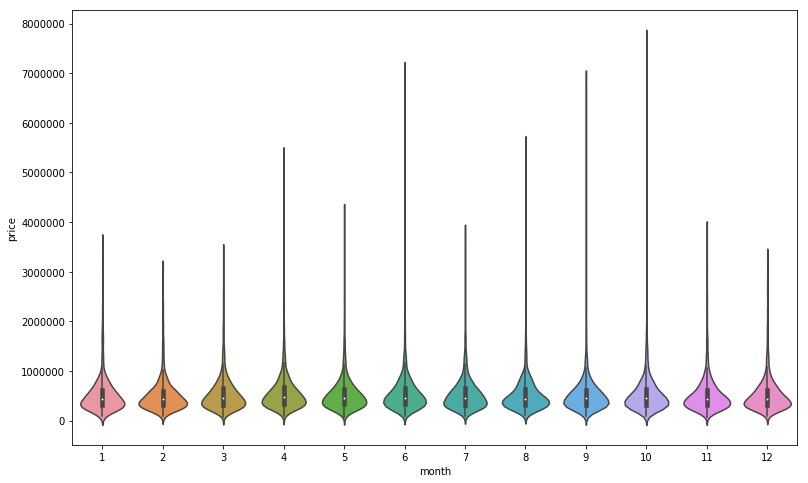

In [90]:
plt.figure(figsize= (13, 8))
sns.violinplot(x= data.month, y= data.price);

In [91]:
plt.figure(figsize= (13, 8))
data[['zone', 'price', 'month']].groupby('month').quantile(.95).mean()

0.95
price    1.146417e+06
zone     2.201550e+03
dtype: float64

<Figure size 936x576 with 0 Axes>

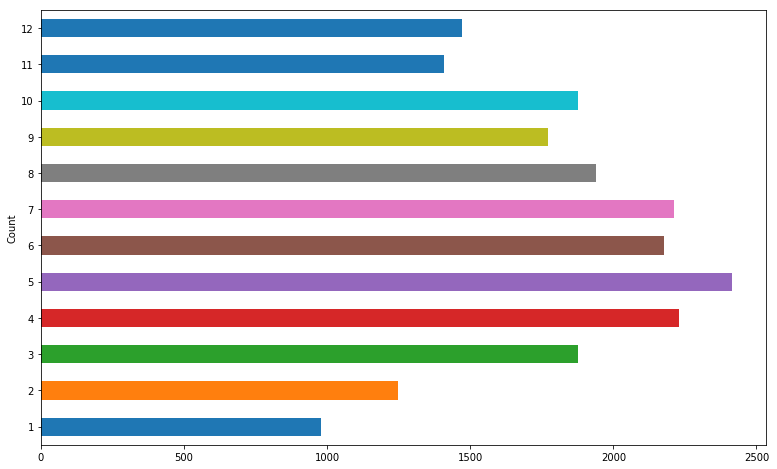

In [92]:
plt.figure(figsize= (13, 8))
a = data.month.value_counts()
a.sort_index().plot(kind= 'barh');
plt.ylabel('Count');

In [93]:
data['log_grade'] = np.log(data["grade"])


#### Creating a Possible Flipped Sale Database
We identified 177 resales of property that were sold in the period of study. We two meanful features:
<ul>
    <li>change_date  The days between sales.</li>
    <li>change_price The cost differential between the previous sale and current sale pric</li>
</ul>

Condition and grade were examined, but there was no change between any of the sales. 


In [94]:
multiple = data.id.value_counts()
len(multiple.loc[multiple > 1])
resales = len(multiple.loc[multiple > 1])
# 176, The number of time a home has been resold in the time period.
resales/ len(data.id)
# Far less then 1% of homes have been sold in the time period.
multiple = multiple.loc[multiple > 1]
multiple = multiple.to_dict()
data['num_sales'] = data.id.map(multiple)
data['num_sales'] = data['num_sales'].fillna(1)
flip = data.loc[data.num_sales > 1]
data = data.drop(columns= 'num_sales')
flip = flip.sort_values('date')

# adding new column examine. 
flip['change_date'] = flip_diff(flip, 'date')

#flip = flip.change_date.apply(lambda x: x.days)      

flip['change_price'] = flip_diff(flip, 'price')

# Removing initial sales
flip = flip.dropna()

# converting timedelta to days
flip.change_date = flip.change_date.apply(lambda x: x.days)

# 
flip['percent_change'] = flip.change_price/(flip.price- flip.change_price)


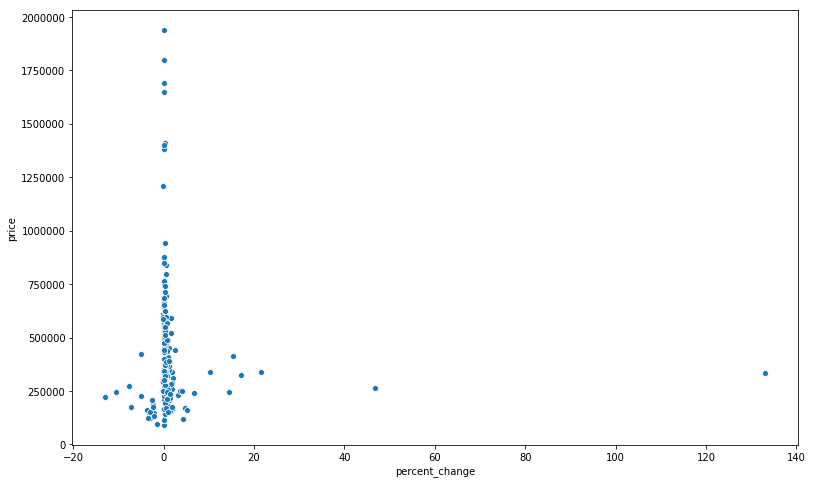

In [95]:
scat_plot(flip, 'percent_change')

In [96]:
data['scaled_log_grade'] = (data['log_grade']-np.mean(data['log_grade']))/np.sqrt(np.var(data['log_grade']))


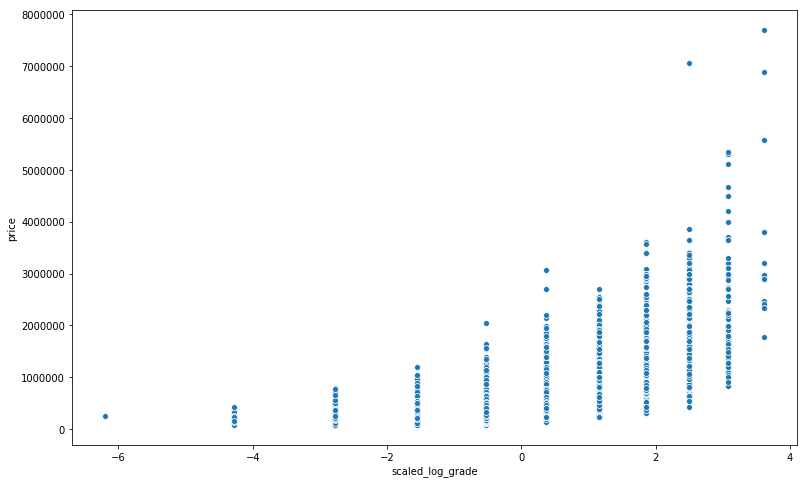

In [97]:
scat_plot(data, 'scaled_log_grade')

0.0682039172107237

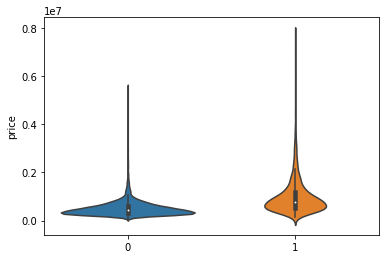

In [98]:
sns.violinplot(x = (1 *(data.price > data.zone_95q)), y = data.price)

a = 1 *(data.price > data.zone_95q)
a.sum()/len(data)


### Exploration (Analysis)

#### Confusion Matrix

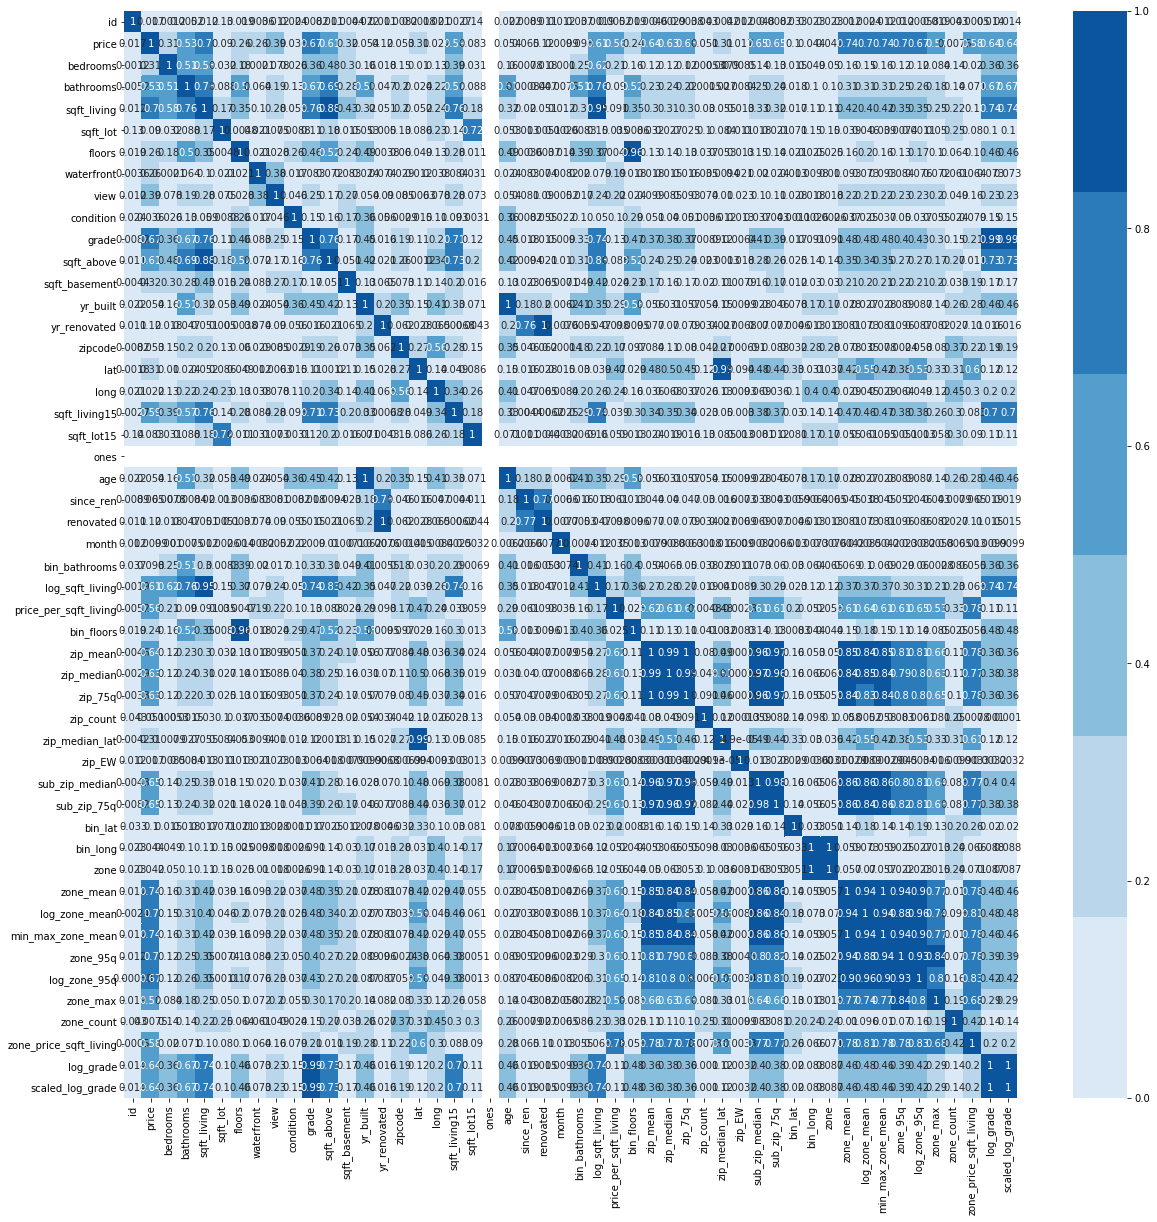

In [99]:
make_heatmap(data=data, figsize=(20, 20))

In [100]:
data.corr().price.abs().sort_values(ascending= False)


price                     1.000000
min_max_zone_mean         0.739220
zone_mean                 0.739220
sqft_living               0.701917
log_zone_mean             0.697515
zone_95q                  0.696062
log_zone_95q              0.668947
grade                     0.667951
sub_zip_75q               0.651066
sub_zip_median            0.647361
zip_mean                  0.638168
scaled_log_grade          0.635153
log_grade                 0.635153
zip_75q                   0.634993
zip_median                0.632561
log_sqft_living           0.611839
sqft_above                0.605368
sqft_living15             0.585241
zone_price_sqft_living    0.575843
zone_max                  0.568236
price_per_sqft_living     0.556056
bathrooms                 0.525906
view                      0.393497
sqft_basement             0.321108
zip_median_lat            0.310784
bedrooms                  0.308787
lat                       0.306692
waterfront                0.264306
floors              

#### Scatter Matrix
Because living space is the most correlated variable, we going to start OLS with sqft_living and add to the OLS going down the correlation list above.  

#### Modeling / Cross Validation

In [101]:
test= pd.DataFrame()

In [102]:
make_ols_model1(df=data, target='price', columns_to_use='sqft_living' , add_constant=True);

#### Data OLS Test 1
<ul>
    <li>R squared is low</li>
    <li>cond no. is high. I will remove constant to see if the improves.</li>
<ul>

In [103]:
make_ols_model1(df=data, target='price', columns_to_use='sqft_living' , add_constant=False);

#### Data OLS Test 2
<ul>
    <li>R squared improved</li>
    <li>Linearity good (only variable).</li>
    <li>Skewness is a problem. -Will try log transform.</li>
<ul>


In [104]:
data['log_sqft_living'] = np.log(data["sqft_living"])

In [105]:
make_ols_model(df=data, target='price', columns_to_use='log_sqft_living' , add_constant=False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                 5.390e+04
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:38:16   Log-Likelihood:            -3.0631e+05
No. Observations:               21597   AIC:                         6.126e+05
Df Residuals:                   21596   BIC:                         6.126e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living    7.3e+04    314.426    2

(<statsmodels.regression.linear_model.OLS at 0x1803f6f49b0>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1803d8530b8>)

#### Data OLS Test 3

<ul>
    <li>R squared better</li>
    <li>Linearity good (only variable).</li>
    <li>Adding grade</li>
<ul>



In [106]:
columns= ['log_sqft_living', 'grade']
make_ols_model1(df=data, target='price', columns_to_use=columns, add_constant=False)

(<statsmodels.regression.linear_model.OLS at 0x1803f3fa668>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1803f3fa828>)

#### Data OLS Test 4
<ul>
    <li>R squared better</li>
    <li>Linearity good.</li>
    <li>Normality is better, but not good.</li>
    <li>Skewing got worst but only by a little. Will try log transform.</li>
</ul>


In [107]:
data['log_grade'] = np.log(data["grade"])
columns= ['log_sqft_living', 'log_grade']
make_ols_model1(df=data, target='price', columns_to_use=columns, add_constant=False);

#### Data OLS Test 5

<ul>
    <li>R squared worse</li>
    <li>Linearity good</li>
    <li>Skewing got better. -Adding basementsqft</li>
</ul>


In [108]:

columns= ['log_sqft_living', 'log_grade', 'sqft_basement']
make_ols_model1(df=data, target='price', columns_to_use=columns, add_constant=False);

#### Data OLS Test 8

<ul>
    <li>R squared worse</li>
    <li>Linearity got worse</li>
    <li>Skewing got better. -Will make basement a categorical feature</li>
</ul>


In [109]:
data['basement'] = data.sqft_basement.replace(to_replace= 0, value= np.nan)
data.basement = data.basement/data.basement
data.basement = data.basement.fillna(0)
columns= ['log_sqft_living', 'log_grade', 'basement']
make_ols_model1(df=data, target='price', columns_to_use=columns, add_constant=False);

#### Data OLS Test 9
<ul>
    <li>R squared better</li>
    <li>Linearity better</li>
    <li>Normality is worse.</li>
    <li>Skewing got worst but only by a little. -Taking out basement and add lat next</li>
</ul>


In [110]:

columns= ['log_sqft_living', 'grade', 'lat']

ols, results = make_ols_model1(df=data, target='price', columns_to_use=columns, add_constant=False)



#### Data OLS Test 10
<ul>
    <li>R squared better</li>
    <li>Skewing got worst but only by a little. -Try log transform</li>
</ul>


In [111]:
data['log_lat'] = np.log(data.lat)
columns= ['log_sqft_living', 'log_grade', 'log_lat']
ols, results = make_ols_model1(df=data, target='price', columns_to_use=columns, add_constant=False)

#### Data OLS Test 11
<ul>
    <li>R squared worse</li>
    <li>I going to see if we can create better location feature. Going to replace lat with zip_mean.</li>
<ul>

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                 4.457e+04
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:38:16   Log-Likelihood:            -2.9852e+05
No. Observations:               21597   AIC:                         5.970e+05
Df Residuals:                   21594   BIC:                         5.971e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living -1.459e+05   1886.642    -

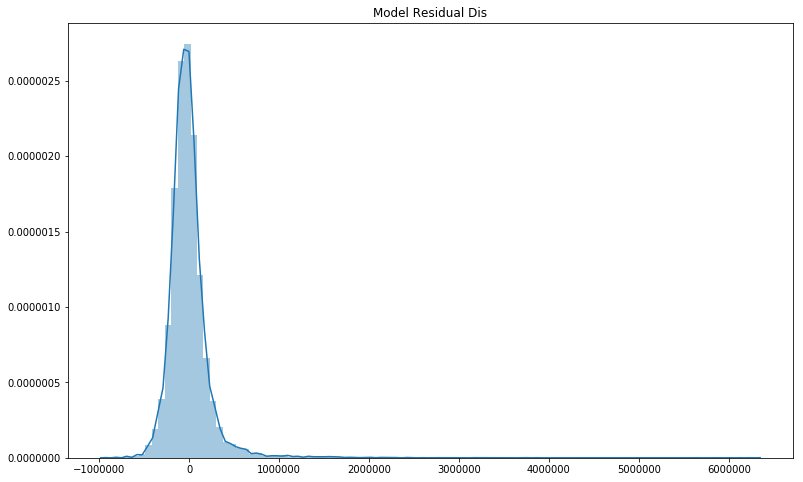

In [112]:
columns= ['log_sqft_living', 'grade', 'zip_mean']
ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
tests= [results.rsquared, results.condition_number]
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');

#### OLS Test 12
<ul>
    <li>R squared worst than test 9</li>
    <li>Cond. No. is out of control.</li>
<ul>

In [113]:

columns= ['log_sqft_living', 'grade', 'zip_median']
ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
tests= [results.rsquared, results.condition_number]

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                 4.326e+04
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:38:17   Log-Likelihood:            -2.9880e+05
No. Observations:               21597   AIC:                         5.976e+05
Df Residuals:                   21594   BIC:                         5.976e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living -1.484e+05   1910.590    -

#### Test 13
Not much better than test 14. - tray higher quantile

In [114]:
columns= ['log_sqft_living', 'grade', 'zip_75q']
ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
tests= [results.rsquared, results.condition_number]


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                 4.468e+04
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:38:17   Log-Likelihood:            -2.9850e+05
No. Observations:               21597   AIC:                         5.970e+05
Df Residuals:                   21594   BIC:                         5.970e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living -1.442e+05   1885.103    -

#### Test 14 
Better than 13. 

Linearity is still problem

In [115]:
columns= ['log_sqft_living', 'grade', 'sub_zip_median' ]
ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
tests= [results.rsquared, results.condition_number]


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                 4.411e+04
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:38:17   Log-Likelihood:            -2.9862e+05
No. Observations:               21597   AIC:                         5.972e+05
Df Residuals:                   21594   BIC:                         5.973e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living -1.427e+05   1896.087    -

#### OLS Test 15
Not good. -Will go back to Test 10, and examine residuals

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                 4.457e+04
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:38:17   Log-Likelihood:            -3.0217e+05
No. Observations:               21597   AIC:                         6.044e+05
Df Residuals:                   21595   BIC:                         6.044e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living -1.498e+05   2233.777    -

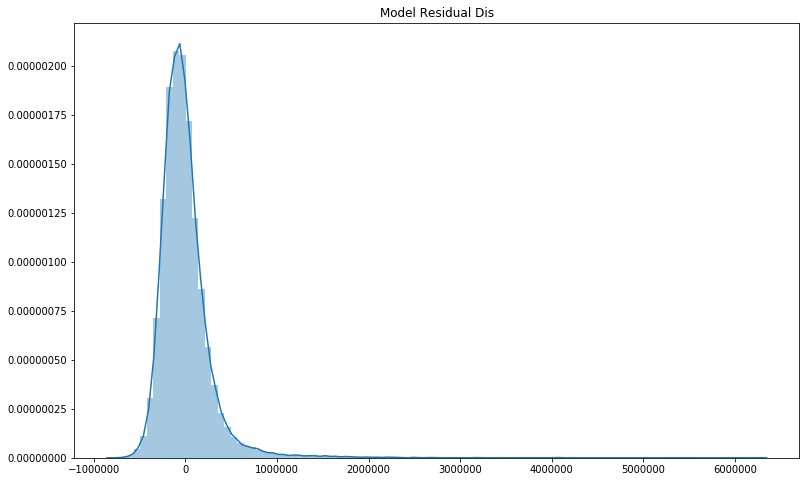

In [116]:

columns= ['log_sqft_living', 'grade']

ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');

Residual is very skewed to the lower end. 

In [117]:
len(a.loc[a.abs() > 2])/len(a)

0.0

#### OLS Test 16
-will add zone_mean- Binned values of lat and long (quantities in each bin) with the mean of the sales price in the area

##### Residual Check 1
Around 3% of the residuals are outside of 2 standard deviations . I will check the model to see if the regression improves.

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                 5.480e+04
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:38:18   Log-Likelihood:            -2.9657e+05
No. Observations:               21597   AIC:                         5.932e+05
Df Residuals:                   21594   BIC:                         5.932e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living -1.139e+05   1748.673    -

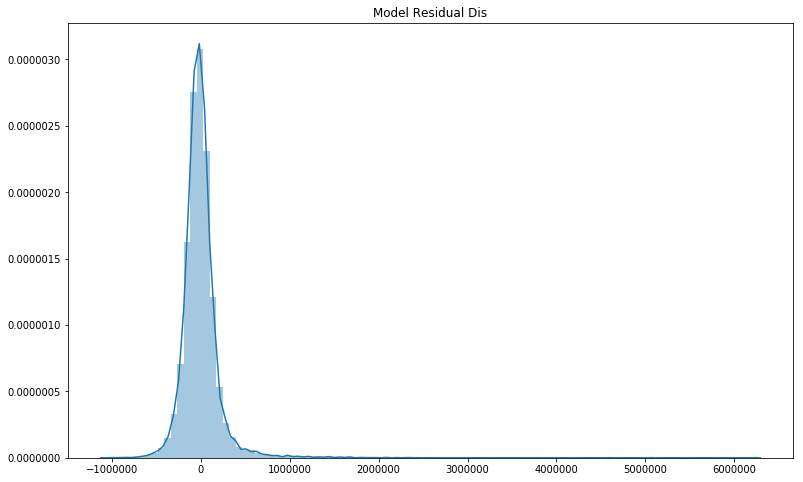

In [118]:
columns= ['log_sqft_living', 'grade', 'zone_mean']

ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');

In [119]:
a=results.resid/results.resid.std()
a = a.loc[a.abs() > 2]
len(a)/len(results.resid)

0.03273602815205816

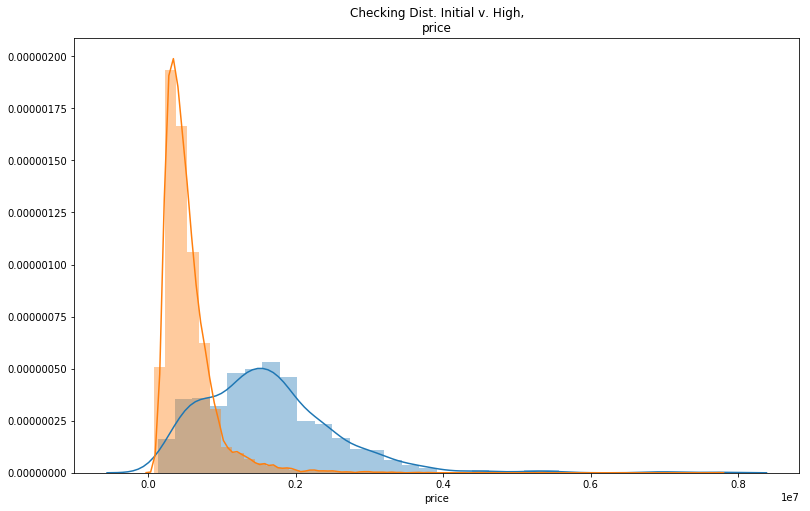

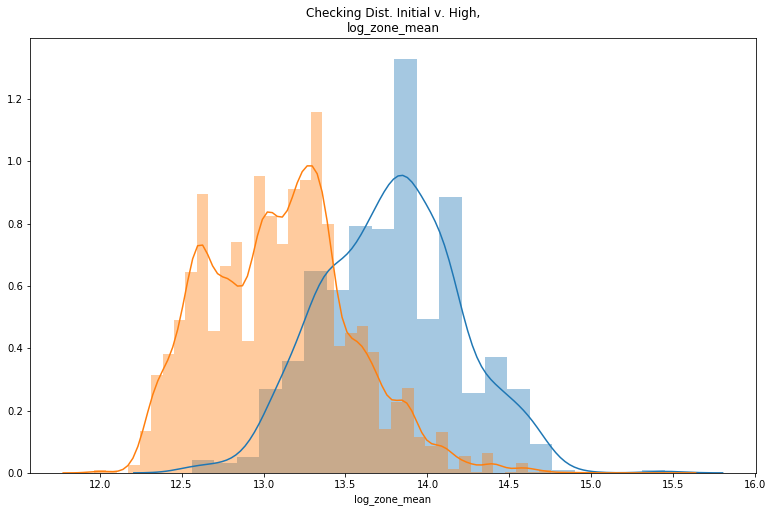

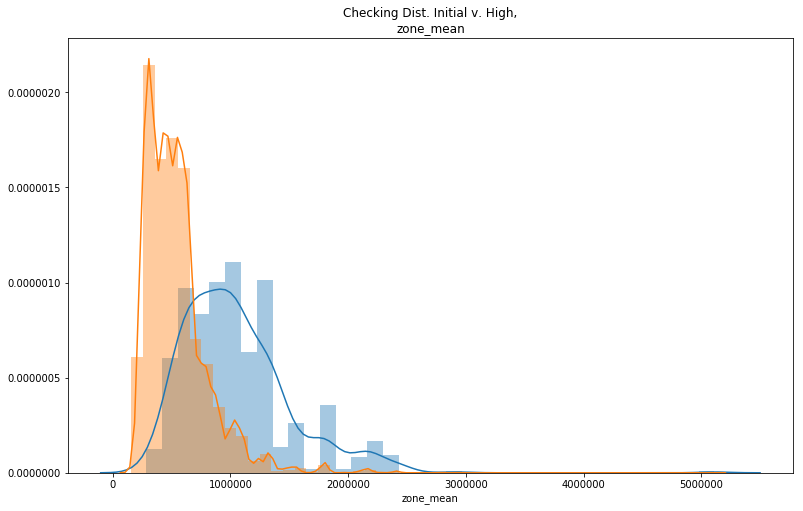

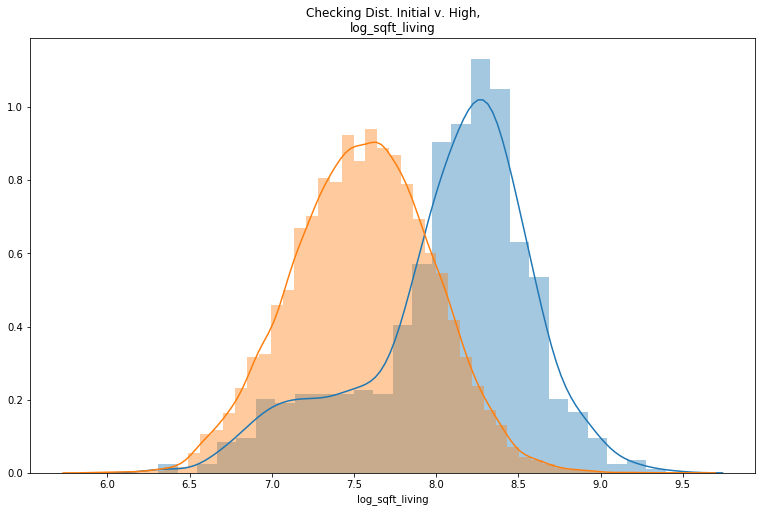

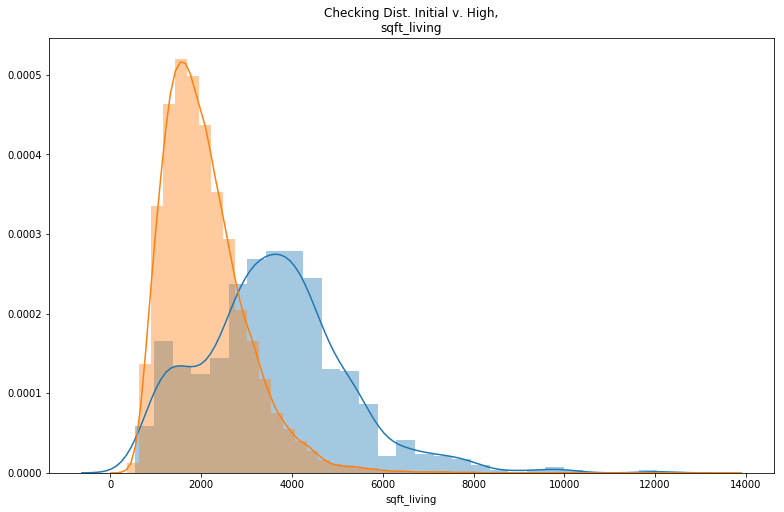

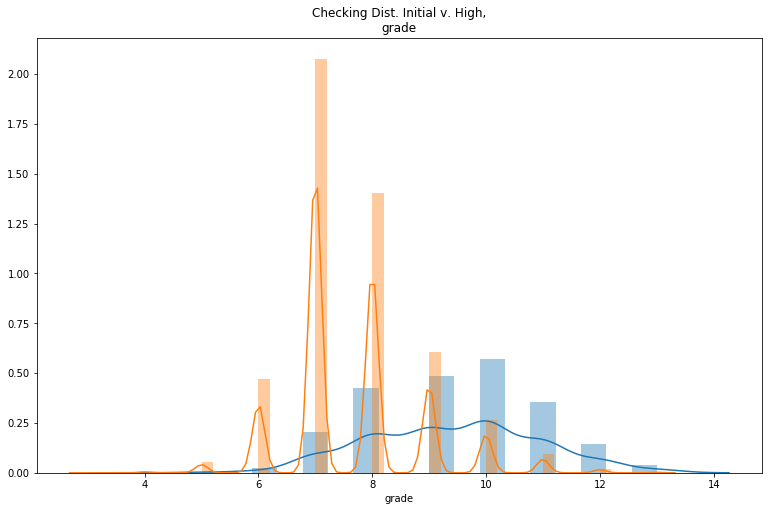

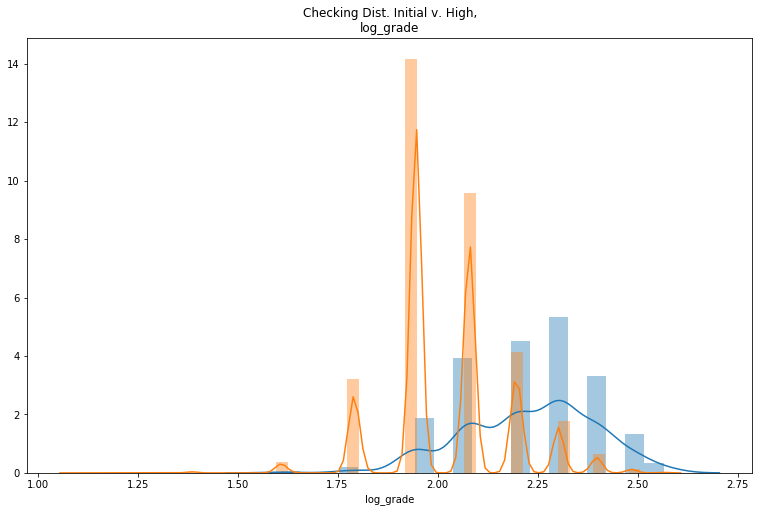

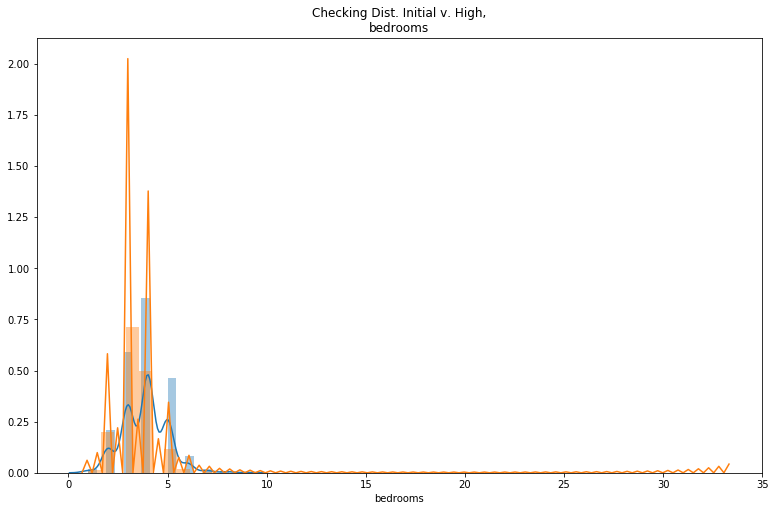

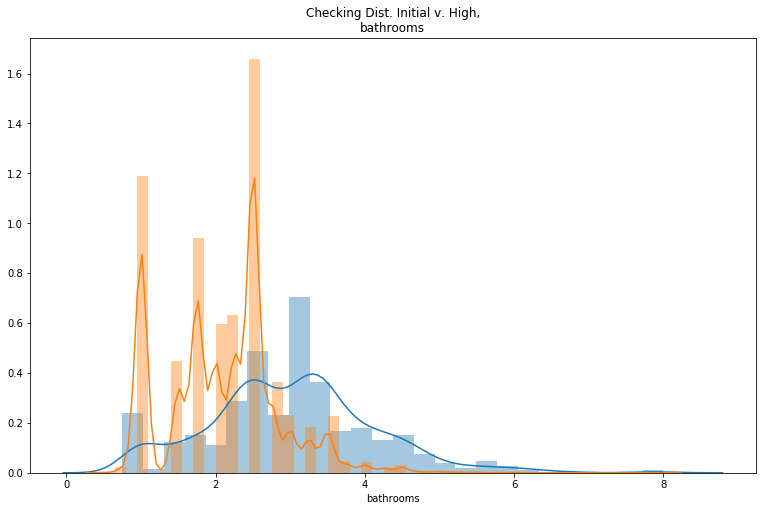

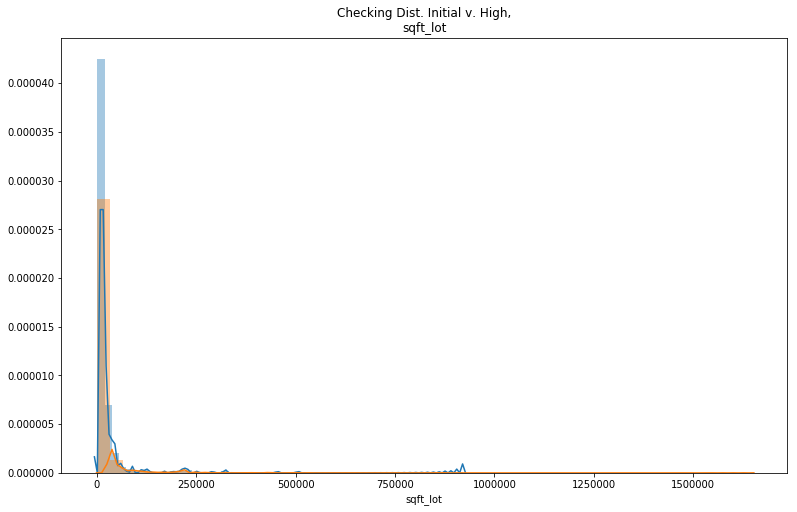

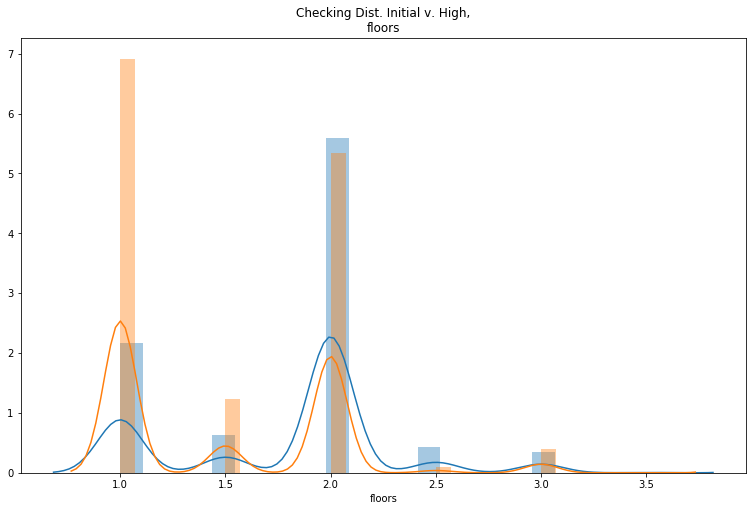

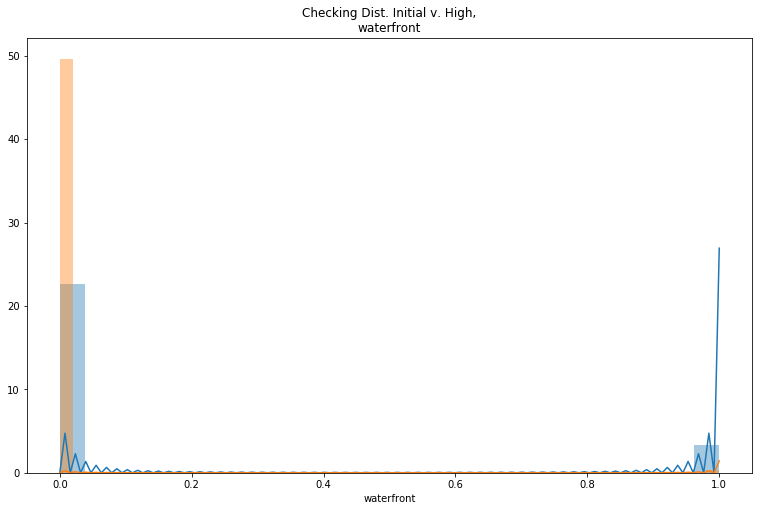

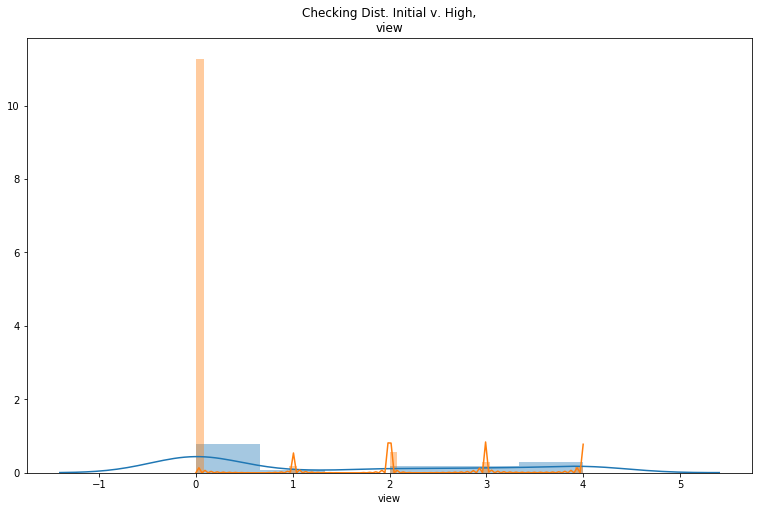

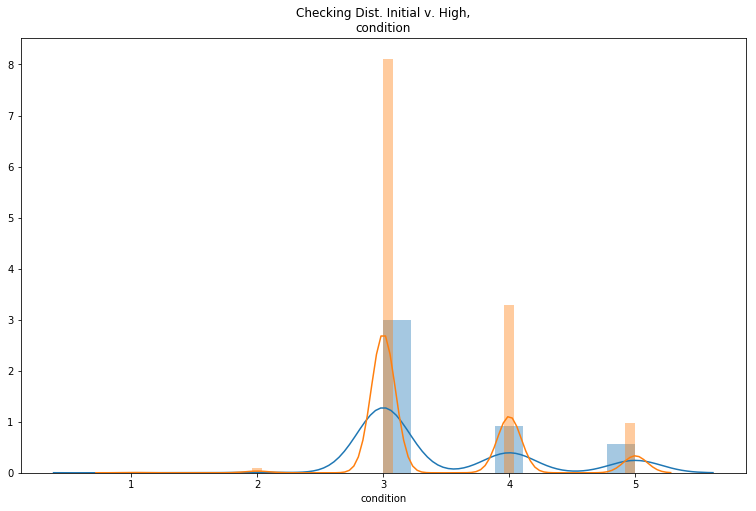

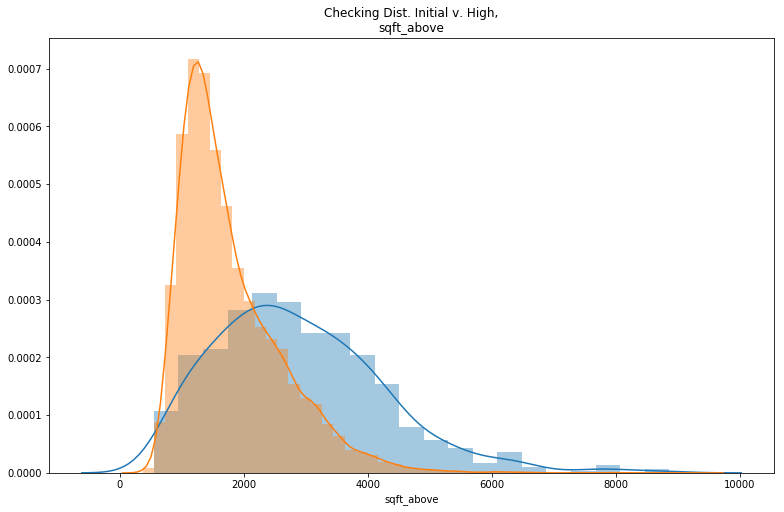

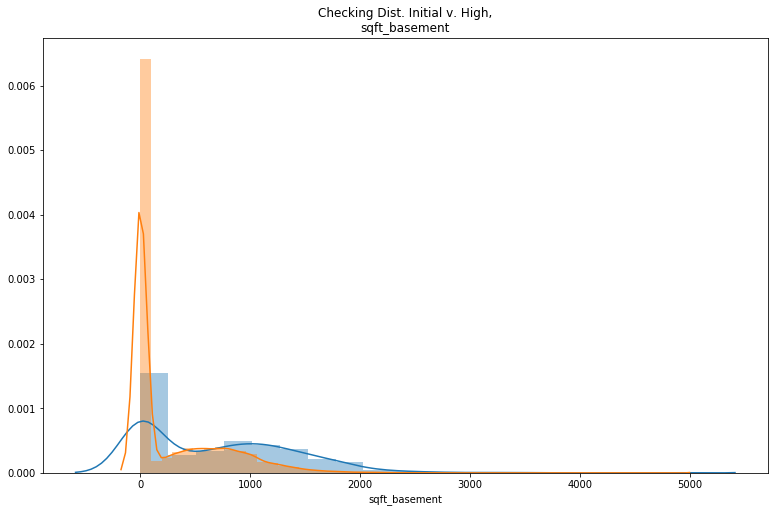

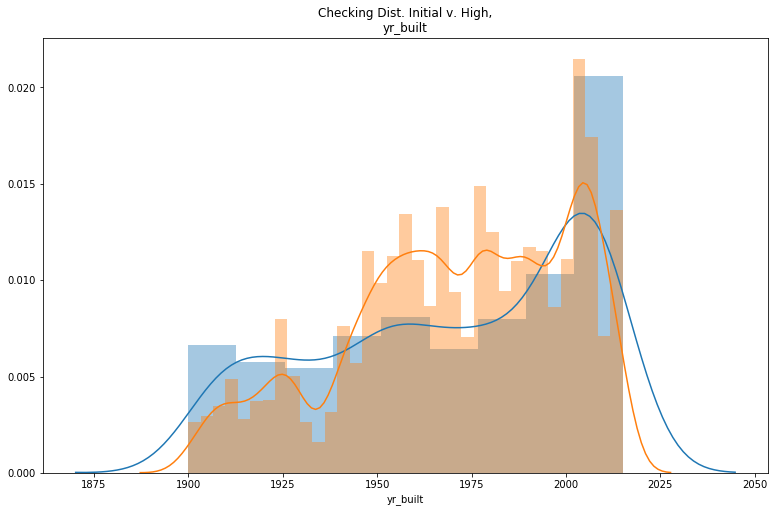

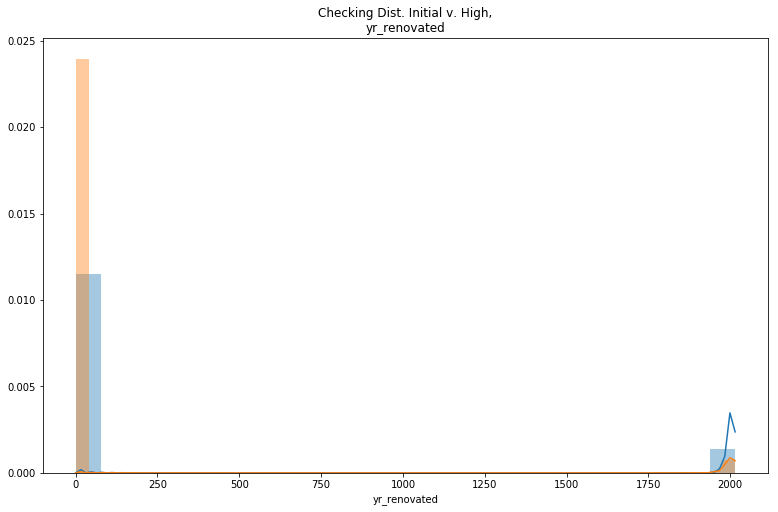

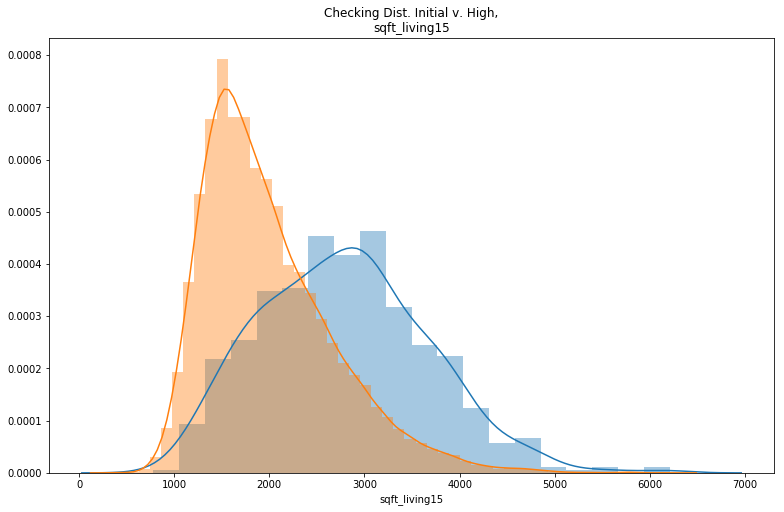

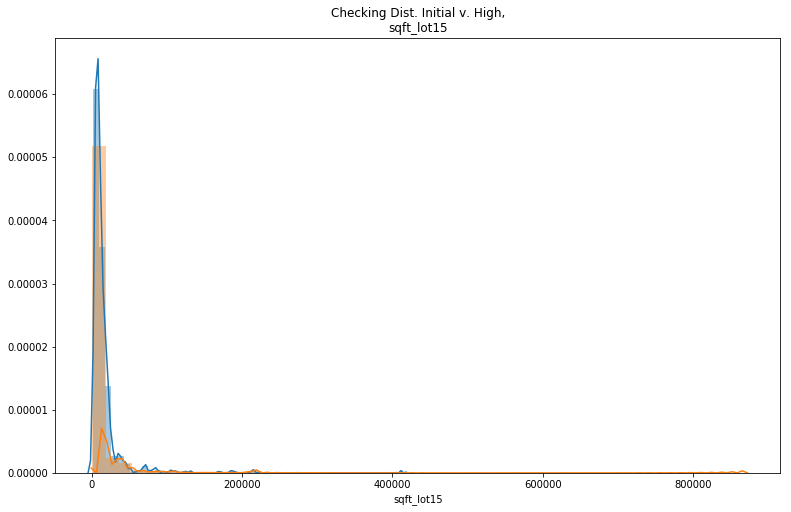

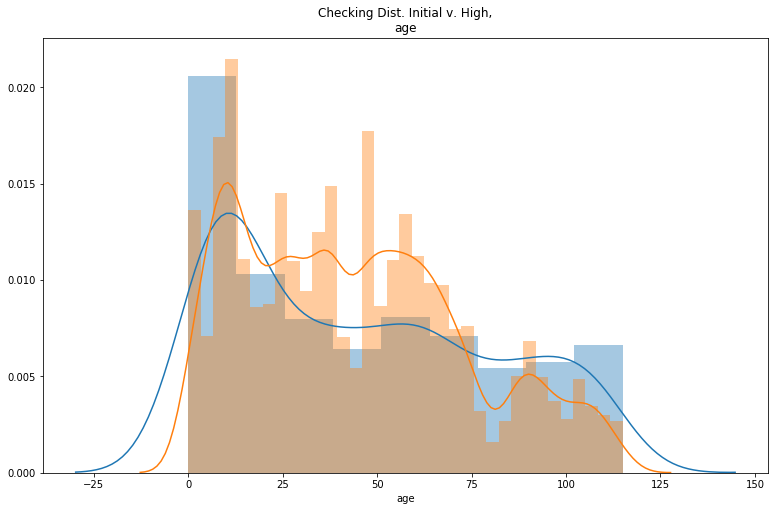

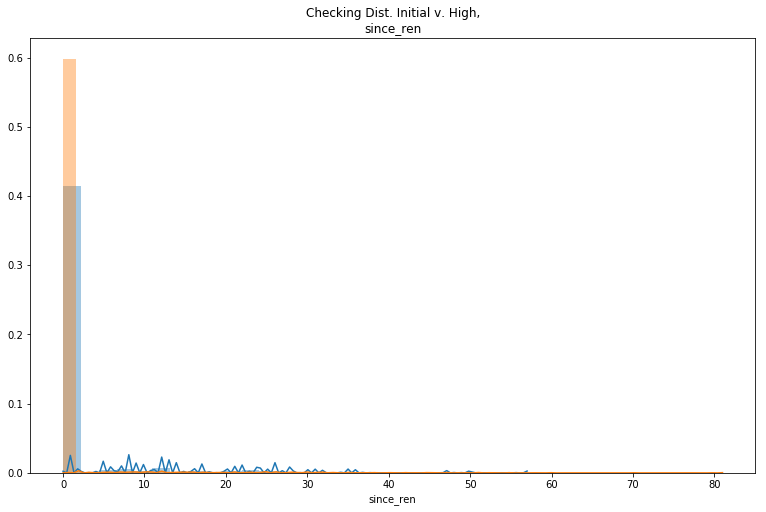

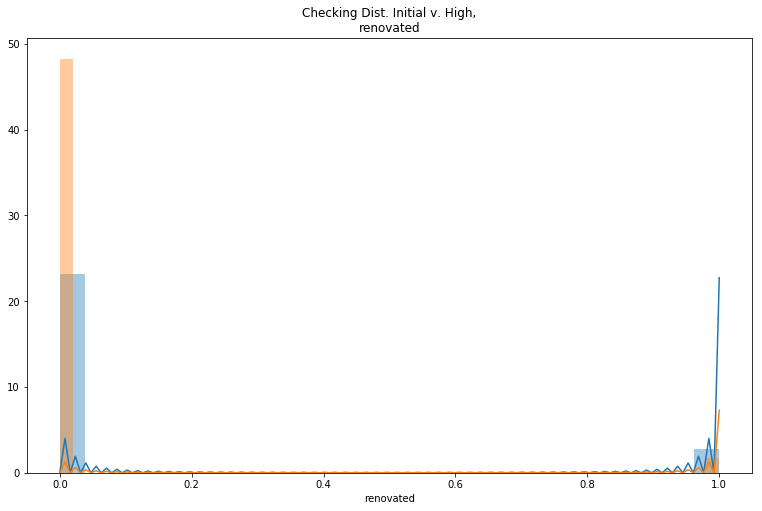

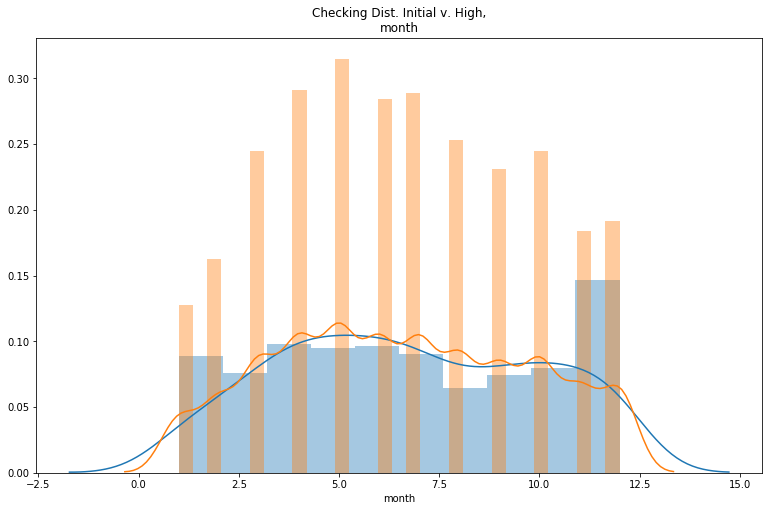

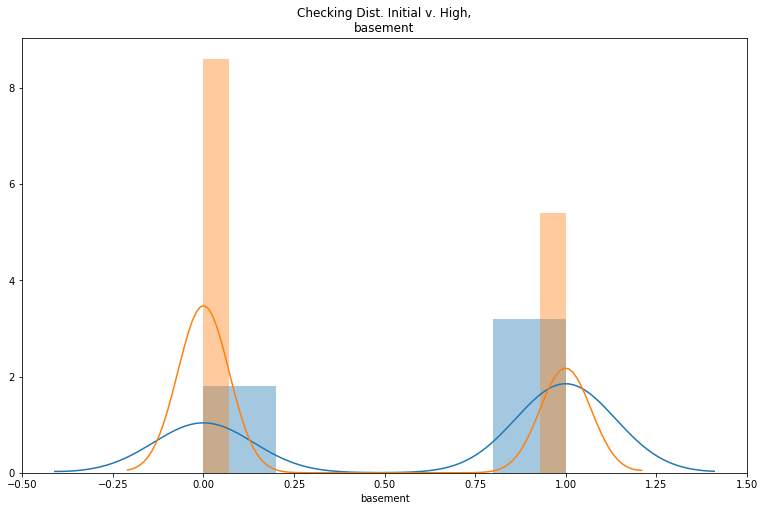

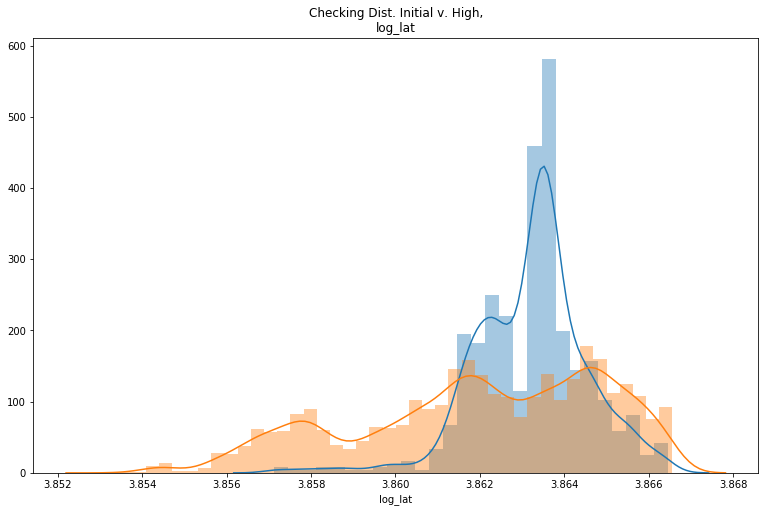

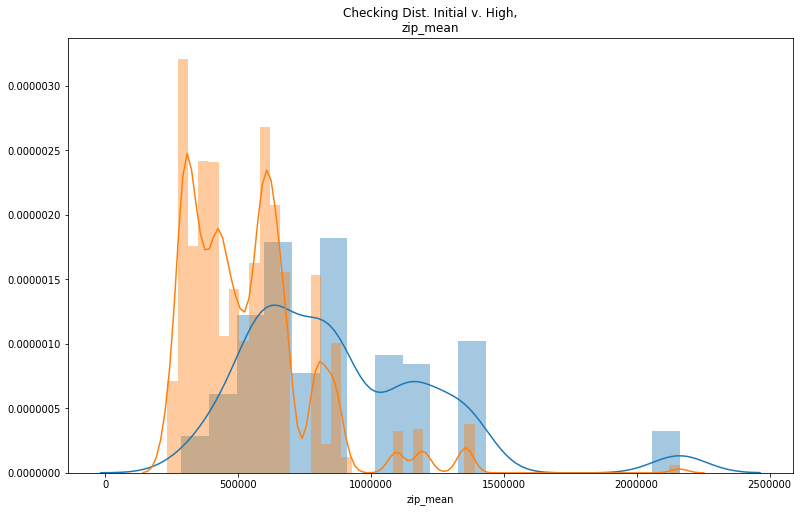

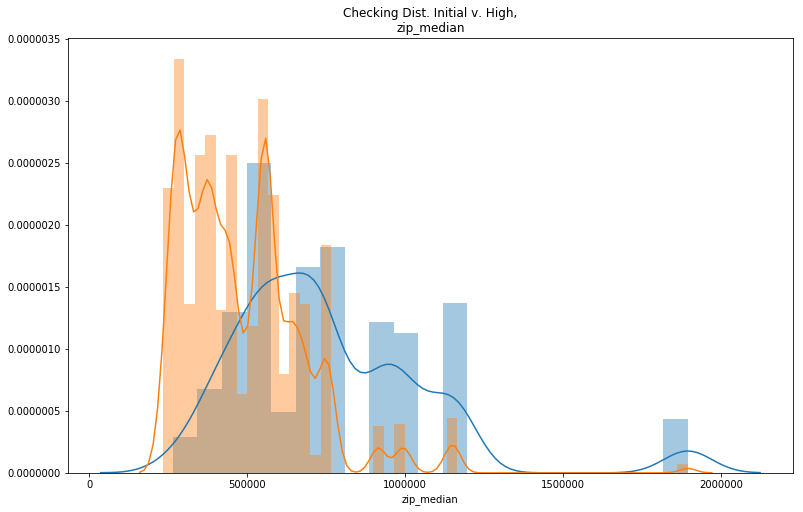

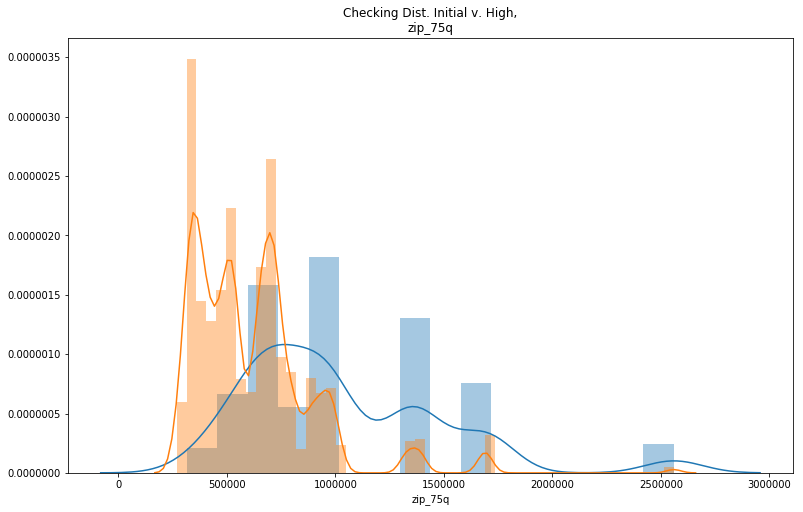

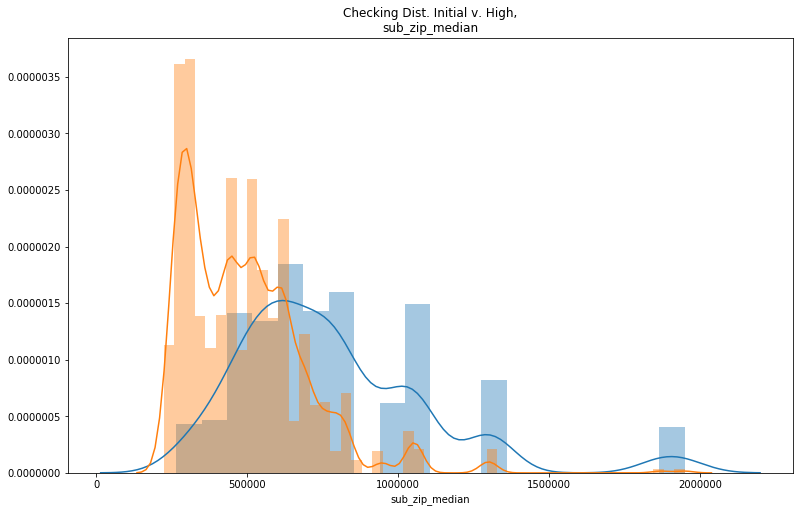

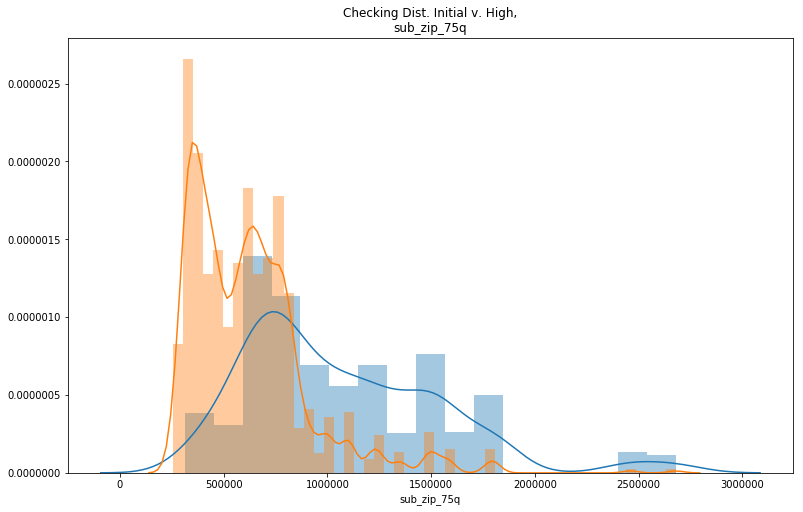

In [120]:
 
for col in ['price',
    'log_zone_mean',
    'zone_mean', 
    'log_sqft_living',
    'sqft_living',
    'grade',
    'log_grade',
    'bedrooms', 
    'bathrooms',
    'sqft_lot',
    'floors',
    'waterfront',
    'view',
    'condition',
    'sqft_above',
    'sqft_basement',
    'yr_built',
    'yr_renovated',
    'sqft_living15',
    'sqft_lot15',
    'age',
    'since_ren',
    'renovated',
    'month',
    'basement',
    'log_lat',
    'zip_mean',
    'zip_median',
    'zip_75q',
    'sub_zip_median',
    'sub_zip_75q']:
    resd_check(results, data, col)

#### OLS Test 17
-will log transform  zone_mean

##### Residual Check 1
Around 3% of the residuals are outside of 2 standard deviations . I will check the model to see if the regression improves.

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:38:31   Log-Likelihood:            -3.0217e+05
No. Observations:               21597   AIC:                         6.043e+05
Df Residuals:                   21594   BIC:                         6.044e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living -1.351e+05   5937.652    -

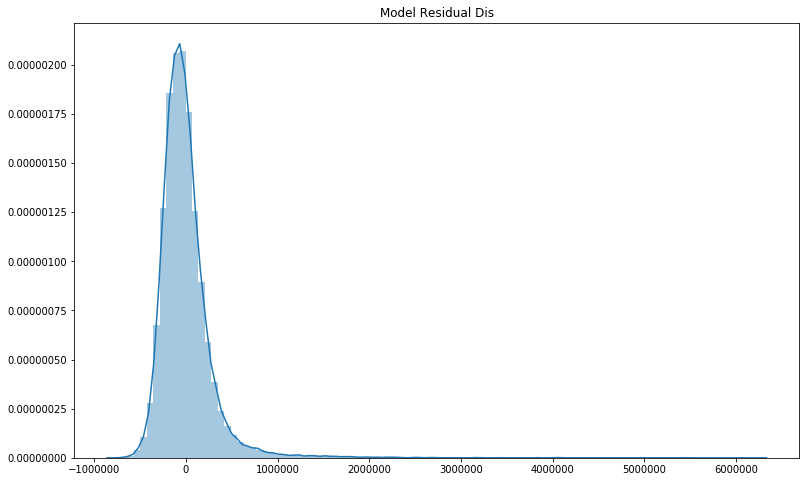

In [121]:
columns= ['log_sqft_living', 'grade', 'log_zone_mean']

ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');

#### Test 18
Linearity good. R squared acceptable. Take out outilier (3%) shouold get better.

Going to min_max scale the log_zone_mean

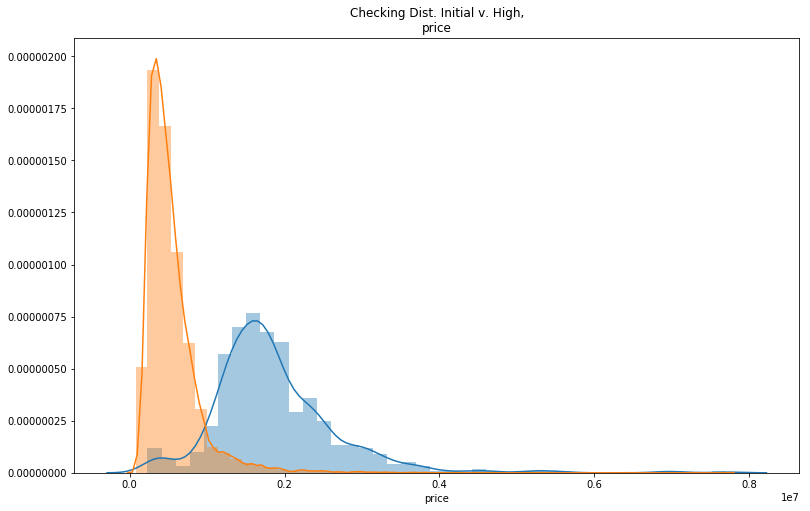

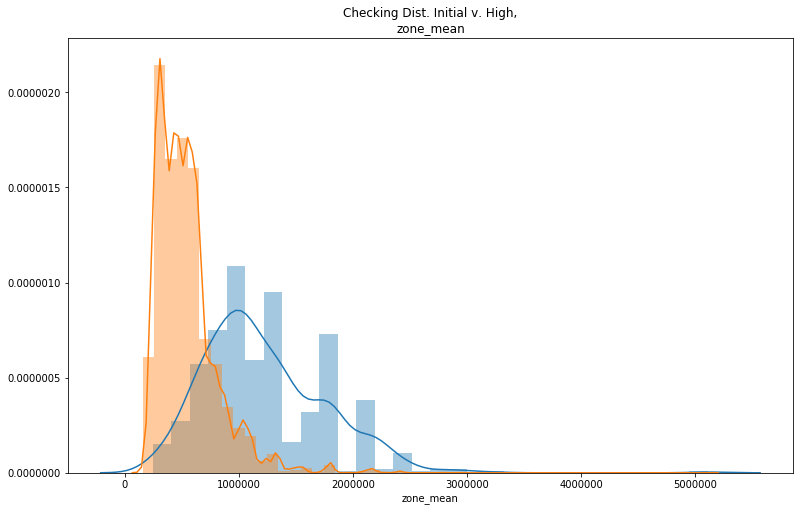

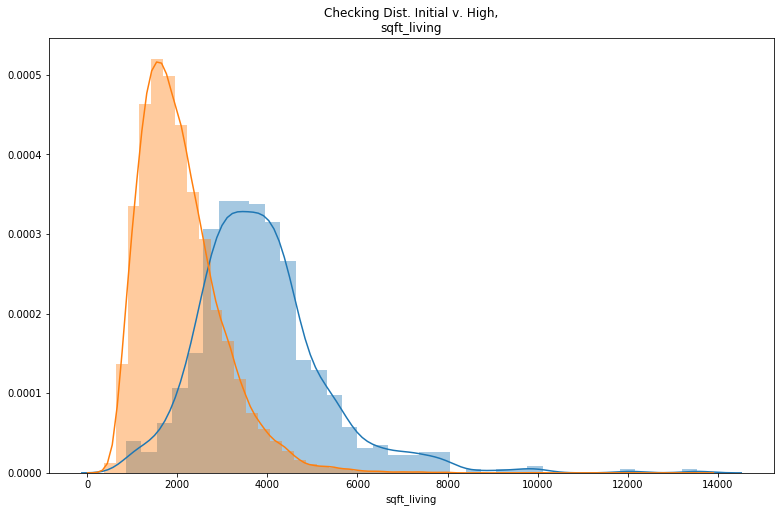

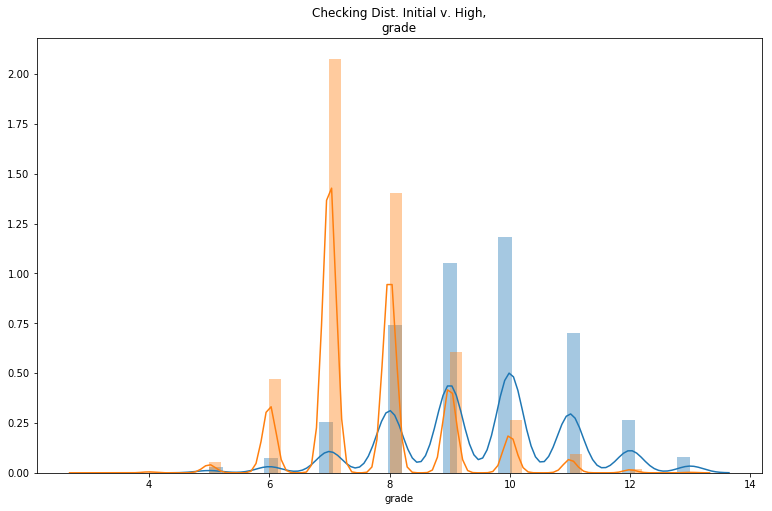

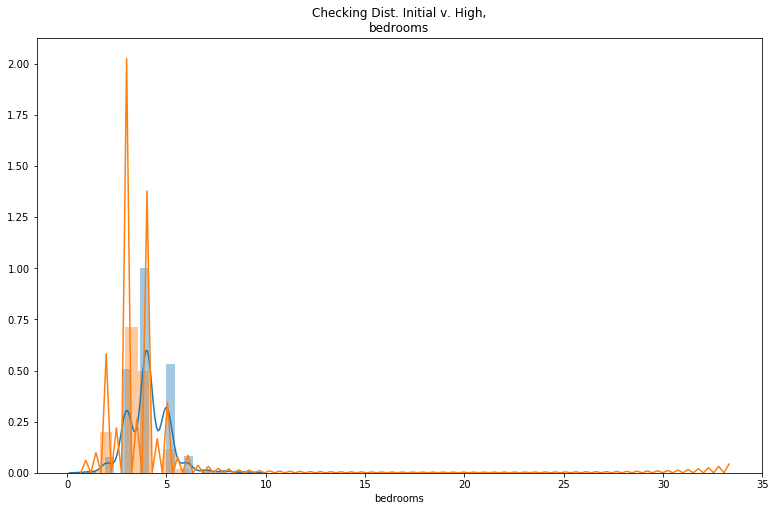

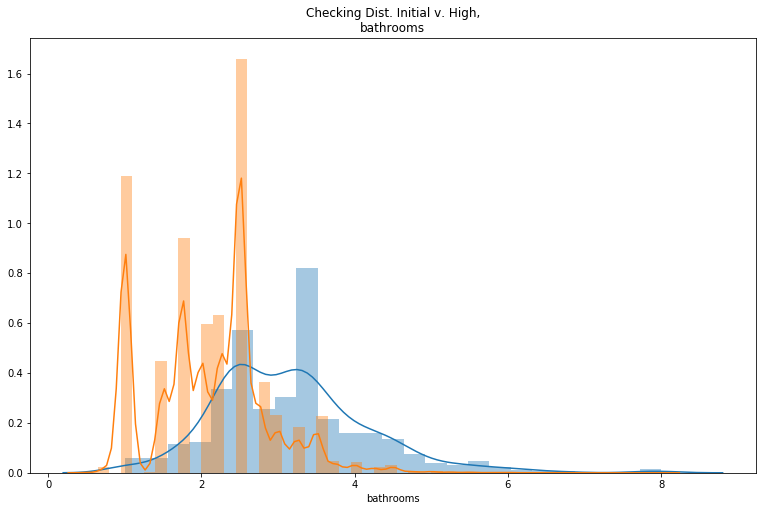

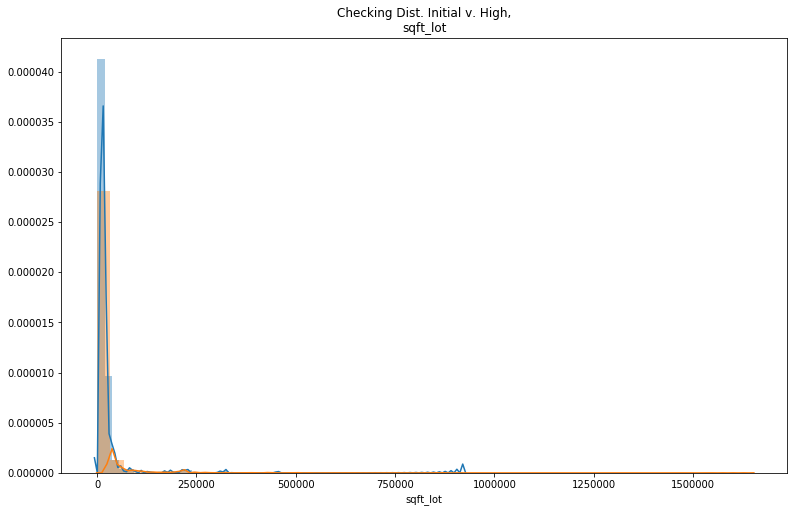

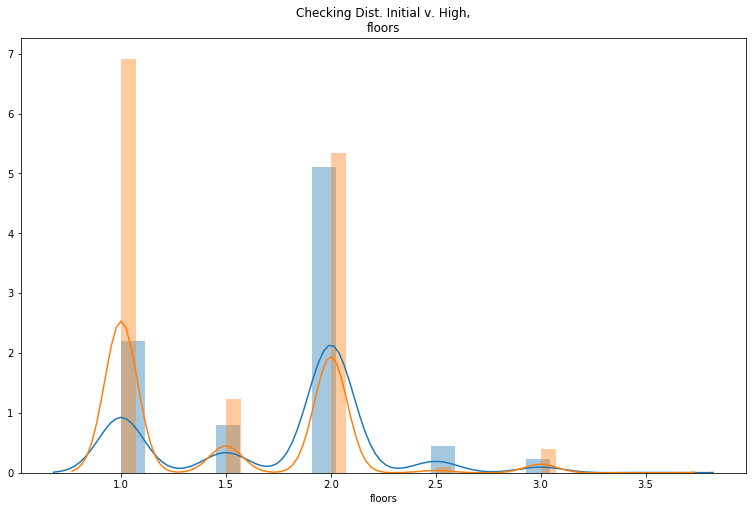

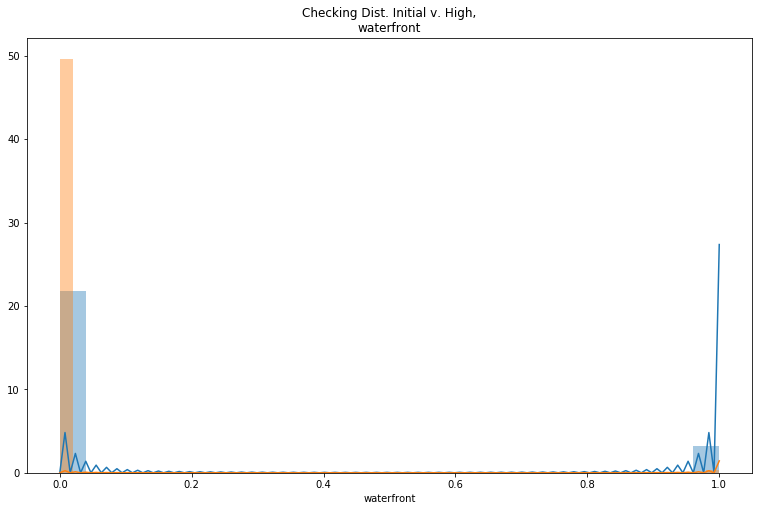

In [ ]:
for col in ['price',
'zone_mean', 
'sqft_living',
'grade',
'bedrooms', 
'bathrooms',
'sqft_lot',
'floors',
'waterfront',
'view',
'condition',
'sqft_above',
'sqft_basement',
'yr_built',
'yr_renovated',
'sqft_living15',
'sqft_lot15',
'age',
'since_ren',
'renovated',
'month',
'basement',
'sub_zip_median',
'sub_zip_75q']:
    resd_check(results, data, col)

In [ ]:
sns.distplot(min_max(data.log_zone_mean))
data['min_max_log_zone_mean'] =min_max(data.log_zone_mean)


In [ ]:
columns= ['log_sqft_living', 'grade', 'min_max_log_zone_mean']

ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');

#### Test 19
Going to min_max scale the grade

In [ ]:
data['min_max_grade'] = min_max(data.grade)

In [ ]:
sns.distplot(min_max(data.grade))


In [ ]:
columns= ['log_sqft_living', 'min_max_grade', 'min_max_log_zone_mean']

ols, results = make_ols_model1(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');
data['residual'] = results.resid
keep_data = data.loc[data.residual.abs() <= data.residual.std()*2] # removed anything above 3 std deviation in the residuals. 
removed_data = data.loc[data.residual.abs() > data.residual.std()*2]  

In [ ]:
for col in ['price',
'zone_mean', 
'sqft_living',
'grade',
'bedrooms', 
'bathrooms',
'sqft_lot',
'floors',
'waterfront',
'view',
'condition',
'sqft_above',
'sqft_basement',
'yr_built',
'yr_renovated',
'sqft_living15',
'sqft_lot15',
'age',
'since_ren',
'renovated',
'month',
'basement',
'sub_zip_median',
'sub_zip_75q']:
    resd_check(results, data, col)

#### Test 20
Adding waterfront

In [ ]:
columns= ['log_sqft_living', 'min_max_grade', 'min_max_log_zone_mean', 'waterfront']

ols, results = make_ols_model1(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');
data['residual'] = results.resid
keep_data = data.loc[data.residual.abs() <= data.residual.std()*2] # removed anything above 3 std deviation in the residuals. 
removed_data = data.loc[data.residual.abs() > data.residual.std()*2]  

In [ ]:
for col in ['price',
'zone_mean', 
'sqft_living',
'grade',
'bedrooms', 
'bathrooms',
'sqft_lot',
'floors',
'waterfront',
'view',
'condition',
'sqft_above',
'sqft_basement',
'yr_built',
'yr_renovated',
'sqft_living15',
'sqft_lot15',
'age',
'since_ren',
'renovated',
'month',
'basement',
'sub_zip_median',
'sub_zip_75q']:
    resd_check(results, data, col)

#### OLS Test 21

#### Separating  residual

In [ ]:
data['residual'] = results.resid
keep_data = data.loc[data.residual.abs() <= data.residual.std()*2] # removed anything above 3 std deviation in the residuals. 
removed_data = data.loc[data.residual.abs() > data.residual.std()*2]  

#### New Variable high_grade
Binary variable for grades with that have removed residual percentages in the last model (3 and grades over 11) other grades recieved a one.

In [ ]:
data['high_grade'] = data.grade
data.high_grade.loc[(data.high_grade <12) & (data.high_grade > 3)] = 1
data.high_grade.loc[(data.high_grade >= 12) | (data.high_grade == 3)] = 0

In [ ]:
columns= ['log_sqft_living', 'min_max_grade', 'min_max_log_zone_mean', 'waterfront', 'high_grade']

ols, results = make_ols_model1(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');
data['residual'] = results.resid
keep_data = data.loc[data.residual.abs() <= data.residual.std()*2] # removed anything above 3 std deviation in the residuals. 
removed_data = data.loc[data.residual.abs() > data.residual.std()*2]  

In [ ]:
for col in ['price',
'zone_mean', 
'sqft_living',
'grade',
'bedrooms', 
'bathrooms',
'sqft_lot',
'floors',
'waterfront',
'view',
'condition',
'sqft_above',
'sqft_basement',
'yr_built',
'yr_renovated',
'sqft_living15',
'sqft_lot15',
'age',
'since_ren',
'renovated',
'month',
'basement',
'sub_zip_median',
'sub_zip_75q']:
    resd_check(results, data, col)

#### OLS Test 22

In [ ]:
columns= ['log_sqft_living', 'min_max_grade', 'min_max_log_zone_mean', 'waterfront', 'high_grade', 'bin_floors']

ols, results = make_ols_model1(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');
data['residual'] = results.resid
keep_data = data.loc[data.residual.abs() <= data.residual.std()*2] # removed anything above 3 std deviation in the residuals. 
removed_data = data.loc[data.residual.abs() > data.residual.std()*2]  

In [ ]:
for col in ['price',
'zone_mean', 
'sqft_living',
'grade',
'bedrooms', 
'bathrooms',
'sqft_lot',
'floors',
'waterfront',
'view',
'condition',
'sqft_above',
'sqft_basement',
'yr_built',
'yr_renovated',
'sqft_living15',
'sqft_lot15',
'age',
'since_ren',
'renovated',
'month',
'basement',
'sub_zip_median',
'sub_zip_75q']:
    resd_check(results, data, col)

#### OLS Test 23

In [ ]:
columns= ['log_sqft_living', 'min_max_grade', 'min_max_log_zone_mean', 'waterfront', 'high_grade', 'bin_floors', 'condition']

ols, results = make_ols_model1(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');
data['residual'] = results.resid
keep_data = data.loc[data.residual.abs() <= data.residual.std()*2] # removed anything above 3 std deviation in the residuals. 
removed_data = data.loc[data.residual.abs() > data.residual.std()*2]  

#### OLS Test 24

In [ ]:
data['lot_living'] = data.sqft_lot15- data.sqft_living15
data.lot_living.loc[data.lot_living <= 0] = 0



In [ ]:
columns= ['log_sqft_living', 'min_max_grade', 'min_max_log_zone_mean', 'waterfront', 'high_grade', 'bin_floors', 'condition']

ols, results = make_ols_model1(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');
data['residual'] = results.resid
data['pred'] = results.predict
keep_data = data.loc[data.residual.abs() <= data.residual.std()*2] # removed anything above 3 std deviation in the residuals. 
removed_data = data.loc[data.residual.abs() > data.residual.std()*2]  

#### OLS Test 25
Using bin_bathrooms

In [ ]:
data.bin_bathrooms = data.bin_bathrooms.astype(str)
data['min_max_zone_mean'] = min_max(dataseries=data.zone_mean)

data.bin_bathrooms.loc[data.bin_bathrooms == '(3.75, 8.0]'] = '0'
data.bin_bathrooms.loc[data.bin_bathrooms == '(0.0, 1.75]'] = '1'
data.bin_bathrooms.loc[data.bin_bathrooms == '(1.75, 3.75]'] = '2'
data.bin_bathrooms = data.bin_bathrooms.astype(int)

In [ ]:
columns= ['log_sqft_living', 'min_max_grade', 'min_max_log_zone_mean', 'waterfront', 'high_grade', 'condition', 'bathrooms']

ols, results = make_ols_model1(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');
data['pred'] = results.predict()
data['residual'] = results.resid
keep_data = data.loc[data.residual.abs() <= data.residual.std()*2] # removed anything above 3 std deviation in the residuals. 
removed_data = data.loc[data.residual.abs() > data.residual.std()*2]  


#### OLS Test 26

In [ ]:
columns= ['log_sqft_living','min_max_grade', 'min_max_zone_mean', 'high_grade', 'condition', 'bedrooms', 'bathrooms']

ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');
data['pred'] = results.predict()
data['residual'] = results.resid
keep_data = data.loc[data.residual.abs() <= data.residual.std()*2] # removed anything above 3 std deviation in the residuals. 
removed_data = data.loc[data.residual.abs() > data.residual.std()*2]  

#### OLS Test 27 Final

Below is the parameters of the linear regression.

In [ ]:
results.params

In [ ]:
a= results.params
print('Sqft Living does not have a easily translatable coefficient because of log transformation.')
print('Grade-- $', int(a[1]/(data.grade.max()-data.grade.min())), 'per change in grade', )
print('Mean Price of the Zone Area-- $', round(a[2]/
                (data.zone_mean.max()-data.zone_mean.min()), 2), 'per change in avg price')
print('Non Standard Grade Penalty-- -$', int(abs(a[3])), 'if grade 3 or grades over 11 ')
print('Condition-- $', int(a[4]), 'per change in condition', )
print('Bedrooms-- $', int(a[5]), 'per change in bedrooms', )
print('Bathrooms-- $', int(a[6]), 'per change in bathrooms', )


#### Cross Validation

In [ ]:
linreg = LinearRegression(fit_intercept= True)

X = keep_data[columns]
Y = keep_data.price


cvs = cross_val_score(linreg, X, Y, cv=20, scoring="r2", )

print('The cross validation R squared is ',round(cvs.mean(), 3),', and the standard deviation is ', round(cvs.std(), 3))



### Interpret

#### High Density Sales Areas

Below is the areas with more that 75 sales. The scale is from 75 to the max zone average, 188.

In [ ]:
base_map = folium.Map(
    location=[data.lat.mean()-data.lat.std(), data.long.median()],
    
    zoom_start=9)

HeatMap(data= data[['lat', 'long', 'ones']].loc[(data.zone_count>= 75) 
    ].groupby(['lat', 'long']).
        sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
#base_map


<img src='/download4.png' alt='High Sales Area'/>

Notice the congregation of sales in the Seattle city center. This areas very desirable because of their proximity to work centers and entertainment venues. Also notice the smaller blobs in the west of the Seattle. These features may show established suburbs, or a new development that came on line in the timeframe on the map.

#### Areas of High Density and High Price.
Below is a map of show areas with high volume (above 75 sales) and high prices, area with the 10% zone means.

In [ ]:
base_map = folium.Map(
    location=[data.lat.mean()-data.lat.std(), data.long.median()],
   
    zoom_start=9)

HeatMap(data= data[['lat', 'long', 'ones']].loc[(data.zone_count> 75) 
    & (data.zone_mean > data.zone_mean.quantile(.9))].groupby(['lat', 'long']).
        sum().reset_index().values.tolist(), radius=10, max_zoom=13).add_to(base_map)
scat_plot(data.loc[(data.zone_count> 75) & (data.zone_mean > data.zone_mean.quantile(.9))], 'sqft_living')
plt.title('Sales in High Density and High Cost Area\n V. Living Space')
plt.xlabel('sqft')
plt.ylabel('$')
#base_map


<img src='/download3.png' alt='High Sales and High Pricing'/>

The above shows areas in Seattle north of downtown showing both high sale density and high pricing. The scatter plot shows a fairly linearity relation between living space and price, and heteroscedasticity is less pronounced. When examining like individual or grouped areas, many of the problem of the entire dataset seems to diminish.

#### Mapping Sales in the 99th Percentile  of Price

In [ ]:
base_map = folium.Map(
    location=[data.lat.mean()-data.lat.std(), data.long.median()],
    tiles='Stamen Terrain',
    zoom_start=9)

HeatMap(data= data[['lat', 'long', 'ones']].loc[(data.price > data.price.quantile(.99))].groupby(['lat', 'long']).
        sum().reset_index().values.tolist(), radius=15, max_zoom=9).add_to(base_map)
print('$',data.price.quantile(.99), ' to ', data.price.max())
#base_map


<img src='/download2.png' alt='High Sales Pricing'/>

The high sales price tend to be concentrated around the waterfront. There seems be a particular concentration around the Lake Washington in Bellevue and a piece of Seattle West across the Lake.

#### Mapping Sales
Below is a heatmap marking individual with one weight (a value 1), showing density sale throughout the county.

In [ ]:
base_map = folium.Map(
    location=[data.lat.mean()-data.lat.std(), data.long.median()],
    tiles='Stamen Terrain',
    zoom_start=9)

HeatMap(data= data[['lat', 'long', 'ones']].groupby(['lat', 'long']).
        sum().reset_index().values.tolist(), radius=7, max_zoom=9, min_opacity=.99).add_to(base_map)
#base_map

<img src='/download1.png' alt='Sales Pricing'/>

#### Mapping Sales Density of New Homes
The map shows high density sales areas on new homes (built since 2012). The weight for each sales is one. 

In [ ]:
base_map = folium.Map(
    location=[data.lat.mean()-data.lat.std(), data.long.median()],
    tiles='Stamen Terrain',
    zoom_start=9)


HeatMap(data= data[['lat', 'long', 'ones']].loc[(data.yr_built >= 2012)].groupby(['lat', 'long']).
        sum().reset_index().values.tolist(), radius=10, max_zoom=9, min_opacity=.99).add_to(base_map)
#base_map

<img src='/download (1).png' alt='Mapping Sales of New Homes'/>

According to the National Association of Home Builders, recent home buyer spending averages $2,368 more in new home then older homes. Pinpointing where new homes are built and sold will allow vendors, retails, contractors, and other professional the sale into the residential market to better target their customers.

In [ ]:
!jupyter nbconvert --to markdown index.ipynb
!mv index.md README.md